#### **0. References**

1. The model implementation is primarily based on the official [MAE repository](https://github.com/facebookresearch/mae) by Facebook Research and the [GSOC 2024 project](https://github.com/ML4SCI/E2E/tree/main/Masked_AutoEncoders_E2E_GSCO24_Shashank_Shukla) by Shashank Shekhar Shukla for the E2E organization.

2. The original model utilizes a Base-ViT architecture, which is considerably large given our limited dataset. To address this, we followed the approach from this [Kaggle notebook](https://www.kaggle.com/code/spsayakpaul/mae-keras) by Sayak Paul and Aritra Roy to reduce the model size.

3. **ChatGPT**: acting as the masked autoencoder for my masked understanding.


#### **1. Libraries**

In [12]:
# Standard Library Imports
import sys
import os
import random
import pathlib
import time
import copy
from collections import Counter

# Third-Party Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns



In [13]:
## GPU check and version check ##
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
print( 'python version : ',sys.version) 
print( 'torch version  : ',torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce RTX 4070 Ti SUPER, 16376 MiB
python version :  3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]
torch version  :  2.5.1+cu121


#### **2. General utils**

In [14]:
## Utility Functions ##
def set_seed(seed):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # only applies to CUDA convolutional operation.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True,warn_only=False)

def plot_loss(train_loss, val_loss, save_path="figures/taskVIA_loss_curve.png"):
    # Set plot style within the function (local to this plot only)
    sns.set(style='whitegrid', context='paper', font_scale=1.4, rc={'axes.edgecolor': 'black', 'axes.linewidth': 1.2})
    plt.rc('font', family='serif', size=12)

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6), dpi=1000)

    # Define visually appealing colors
    colors = ['crimson', 'navy']

    plt.plot(epochs, train_loss, label=f"Training Loss", color=colors[0], linewidth=2.5)
    plt.plot(epochs, val_loss, label=f"Validation Loss", color=colors[1], linewidth=2.5, linestyle='--')

    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')

    plt.legend(loc="upper right", fontsize=11, frameon=True, shadow=True)

    plt.grid(alpha=0.3)

    # Adjust axis limits dynamically with margin
    all_losses = train_loss + val_loss
    min_loss, max_loss = min(all_losses), max(all_losses)
    margin = (max_loss - min_loss) * 0.1
    plt.ylim(min_loss - margin, max_loss + margin)

    plt.tight_layout()

    # Create directory if it doesn't exist
    dir_name = os.path.dirname(save_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)

    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    plt.show()

# Define the high-quality training metrics plotting function
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies, save_path='figures/taskVIA_training_metrics.png'):
    epochs = range(1, len(train_losses) + 1)
    
    # Set up high quality figure parameters
    plt.figure(figsize=(12, 6), dpi=1000)
    plt.rc('font', family='serif', size=12)
    
    # Create subplots with consistent high quality styling
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=1000)
    
    # Loss Curve
    ax1.plot(epochs, train_losses, label='Train Loss', color='navy', lw=2.5, linestyle='-')
    ax1.plot(epochs, val_losses, label='Validation Loss', color='crimson', lw=2.5, linestyle='-')
    ax1.set_title('Loss vs. Epochs', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(loc='best', fontsize=12, frameon=True, shadow=True)
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Accuracy Curve
    ax2.plot(epochs, train_accuracies, label='Train Accuracy', color='navy', lw=2.5, linestyle='-')
    ax2.plot(epochs, val_accuracies, label='Validation Accuracy', color='crimson', lw=2.5, linestyle='-')
    ax2.set_title('Accuracy vs. Epochs', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(loc='best', fontsize=12, frameon=True, shadow=True)
    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    plt.show()


def get_class_distribution(dataset, class_to_idx):
    """Returns the class distribution as a sorted dictionary by class names"""
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    labels = [label.item() for _, label in dataset]  # Extract labels
    class_counts = Counter(labels)  # Count occurrences

    return {idx_to_class[k]: class_counts[k] for k in sorted(class_counts.keys(), key=lambda x: idx_to_class[x])}

def ROC_AUC_curves(all_labels, all_probs, class_names=None, save_path=r'figures\taskVIA_roc_curve.png'):  
    num_classes = all_probs.shape[1]
    all_labels_onehot = np.eye(num_classes)[all_labels]

    # Dictionaries to hold FPR, TPR, and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}

    # Set up figure parameters for high quality with adjusted font sizes
    plt.figure(figsize=(5.6, 4.2), dpi=1000)
    plt.rc('font', family='serif', size=9)  # Reduced base font size

    # Manually define a visually appealing color palette
    colors = ['crimson','navy', 'purple', 'forestgreen', 'purple', 'crimson', 'teal', 'gold', 'brown', 'magenta', 'deepskyblue']

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        label = f'{class_names[i]}' if class_names else f'Class {i}'
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,  # Slightly reduced line width
                 label=f'{label} (AUC = {roc_auc[i]:.3f})')
        print(f"{label} AUC: {roc_auc[i]:.4f}")

    # Plot diagonal chance line
    plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', alpha=0.8)  # Reduced line width

    # Axes limits, labels, and title with reduced font sizes
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=11)  # Reduced font size
    plt.ylabel('True Positive Rate', fontsize=11)  # Reduced font size
    plt.title('ROC Curve - One vs. Rest', fontsize=12, fontweight='bold')  # Reduced font size

    # Customize legend with reduced font size
    plt.legend(loc="lower right", fontsize=8, frameon=True, shadow=True)  # Reduced font size

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    plt.show()

def mean_std(train_dataset, device):
    train_dataloader = DataLoader(train_dataset, batch_size=4096, shuffle=False)
    train_data = []

    for image_batch,_ in tqdm(train_dataloader):
        image_batch = image_batch.to(device)
        train_data.append(image_batch)
    
    train_data = torch.cat(train_data, dim=0)
    mean = train_data.mean()
    std = train_data.std()

    return mean, std


#### **3. Dataset utils**

In [15]:
def find_classes(directory):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

class CustomDataset(Dataset): # inherits from torch.utils.data.Dataset class
    def __init__(self, target_dir, transform=None):
        self.paths = list(pathlib.Path(target_dir).rglob('*/*.npy')) # get all the paths of
        # files in the target directory's subdirectories.
        self.transform = transform
        self.classes,self.class_to_idx = find_classes(target_dir)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img_path = self.paths[index]
        img = np.load(img_path)      
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        class_name = img_path.parent.name # get the parent directory name of the image
        label = torch.tensor(self.class_to_idx[class_name],dtype=torch.int64)

        if self.transform:
            img = self.transform(img)
        
        return img, label 

#### **4. Training utils** 

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs. Restoring best weights ......."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False
    

class Trainer_finetune:
    def __init__(self, model, device, HP ,verbose=1):
        self.model = model
        self.device =device
        self.epochs = HP['num_epochs']
        self.batch_size = HP['batch_size']
        self.lr = HP['lr']
        self.weight_decay = HP['weight_decay']
        self.verbose = verbose
    
    ## inference_one_epoch ##
    def inference_one_epoch(self,val_loader,criterion,roc=False ):

        self.model.eval()
        
        correct_validation = 0
        total_validation = 0
        running_val_loss = 0.0

        all_labels = []
        all_probs = []  # to store probabilities for ROC curve

        with torch.no_grad():
            for images, labels in val_loader:
                
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()\
                
                all_labels.extend(labels.cpu().numpy())
        
                # Obtain softmax probabilities
                probs = F.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_validation / total_validation

        all_labels = np.array(all_labels) # (N,)
        all_probs = np.array(all_probs) # (N, num_classes)
        # Calculate ROC AUC curves
        if roc:
            print( 'Calculating ROC AUC curves on validation set...')
            ROC_AUC_curves(all_labels, all_probs)

        return val_loss,val_accuracy


    ## train_one_epoch ##
    def train_one_epoch(self,train_loader,optimizer,criterion):
        
        self.model.train()
        
        start_time = time.time()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for images,labels in tqdm(train_loader):
            # print( 'working')
            images = images.to(self.device)  
            labels = labels.to(self.device)
                
            optimizer.zero_grad()
            outputs = self.model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        epoch_time = time.time()-start_time
        
        return epoch_loss, epoch_acc, epoch_time
    
    ## trainer ##
    def model_train(self,train_loader,val_loader):

        optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr, weight_decay= self.weight_decay)
        # optimizer = torch.optim.AdamW(self.model.backbone.parameters(), lr=self.lr, weight_decay=self.weight_decay)   
        criterion = nn.CrossEntropyLoss()
        es = EarlyStopping(patience=5, min_delta=0.0 ,restore_best_weights=True)

        train_losses, train_accuracies, val_losses, val_accuracies = [],[],[],[]

        for epoch in range(self.epochs):

            # training
            train_loss, train_acc, epoch_time = self.train_one_epoch(train_loader,optimizer,
                                                    criterion)
            
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            if self.verbose in [1,2]:
                print(f'epoch [{epoch+1}/{self.epochs}], train_loss: {train_loss:.4f}, train_accuracy: {train_acc:.2f}%, Time:{epoch_time:.2f} seconds')   
            
            # validating
            roc = True if epoch % 4 == 0 else False 
            val_loss, val_acc = self.inference_one_epoch(val_loader,criterion,roc)
            
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if self.verbose in [1,2]:
                print(f'validation_loss: {val_loss:.4f}, validation_accuracy: {val_acc:.2f}%\n')
            
            

            if es(self.model,val_loss):
                print(es.status)
                break

        if self.verbose in [1,3]:
            plot_training_metrics(train_losses,train_accuracies,val_losses,val_accuracies)


#### **5. Finetuning pre-trained MAE for classification**

##### *5.1 Config*

In [17]:
## TO-CHANGE CELL ##
HP={
'seed': 100, 
'lr': 1e-4,
'batch_size': 256,
'num_epochs':40,
'weight_decay': 0
}

data_dir = r'C:\Users\Admin\Desktop\GSOC\datasets\dataset-deeplense-specific-test-VI.A'
model_path = r'saved_models\best_model_60epochs_zscore.pth'
## TO-CHANGE CELL ##


##### *5.2 Data loading*

The dataset was divided into training, validation, and test sets in a 70:10:20 ratio. Final performance metrics—ROC-AUC and Top-1 accuracy—were evaluated on the test set. For initial data preparation, z-score normalization was applied to all sets using the mean and standard deviation of the training set.

In [18]:
## S1 : DATA LOADING ##

set_seed(HP['seed'])
dataset = CustomDataset(data_dir)
print( 'length of dataset :', len(dataset)) 
print( 'Lablelling format : ', dataset.class_to_idx )

## train-test split ##
from torch.utils.data import random_split   

# Define split sizes
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.1* len(dataset))   # 10% for validation
test_size = len(dataset) - train_size - val_size  # 20% for testing 

# Perform two-step random splitting
train_dataset, temp_dataset = random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# Apply normalization
train_mean, train_std = mean_std(train_dataset, device)
from torchvision.transforms import Normalize    
normalize = Normalize(mean=(train_mean,), std=(train_std,)) 
train_dataset.transform = normalize 
val_dataset.transform = normalize   
test_dataset.transform = normalize  


# Create data loaders   
from torch.utils.data import DataLoader 

train_loader = DataLoader(train_dataset, batch_size=HP['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=HP['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=HP['batch_size'], shuffle=False)     




length of dataset : 89104
Lablelling format :  {'axion_copy': 0, 'cdm': 1, 'no_sub': 2}


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


In [8]:
print('Total dataset  :', get_class_distribution(dataset,dataset.class_to_idx) )
print('Train dataset  :', get_class_distribution(train_dataset,dataset.class_to_idx) )
print('Val dataset    :', get_class_distribution(val_dataset,dataset.class_to_idx) )
print('Test dataset   :', get_class_distribution(test_dataset,dataset.class_to_idx) )

Total dataset  : {'axion_copy': 29896, 'cdm': 29759, 'no_sub': 29449}
Train dataset  : {'axion_copy': 20971, 'cdm': 20768, 'no_sub': 20633}
Val dataset    : {'axion_copy': 2876, 'cdm': 3078, 'no_sub': 2956}
Test dataset   : {'axion_copy': 6049, 'cdm': 5913, 'no_sub': 5860}


##### *5.3 Model Definition*

In [19]:
## S2 : MODEL DEFINING ##

class MAE_encoder(nn.Module):
    def __init__(self, pretrained_model):
        super(MAE_encoder, self).__init__()
        self.encoder = pretrained_model.encoder 
        self.patch_embed = self.encoder.patch_embed 
        self.patchify = self.encoder.patchify   
        self.cls_token = self.encoder.cls_token 
        self.pos_embed = self.encoder.pos_embed 
        self.blocks = self.encoder.blocks
        self.layer_norm = self.encoder.norm

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(64, 3)
        )
        
        self.init_weights()
    def init_weights(self):
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x (B,1,64,64)
    
        # x = self.patchify(x) # (B, 64 , 64) <=> (B, seq_len, d_model)
        x = self.patch_embed(x) # (B, 64, 128)

        x = x + self.pos_embed[:,1:,:]  # (B, 64, 128)

        # appending cls token to the input
        cls_token = self.cls_token + self.pos_embed[:,0:1,:] # (1, 1, 128)
        cls_tokens = cls_token.expand(x.shape[0], -1, -1) # (B, 1, 128)
        x = torch.cat((cls_tokens, x), dim=1) # (B, 65, 128)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        
        x = self.layer_norm(x) # (B, 65, 128)
        
        x = x[:,1:,:] # (B, 64, 128)
        x = self.avg_pool(x) # (B, 64, 1)
        x = x.squeeze(-1) # (B, 64)
        output = self.classifier(x) # (B, 3)

        return output   
   


##### *5.4 Training*

C:\Users\Admin\AppData\Local\Temp\ipykernel_22252\4224472445.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load(model_path)
c:\Users\Admin\ana

Trainable parameters : 803779


100%|██████████| 244/244 [00:26<00:00,  9.35it/s]


epoch [1/40], train_loss: 1.0662, train_accuracy: 46.79%, Time:26.10 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9066
Class 1 AUC: 0.8116
Class 2 AUC: 0.9370


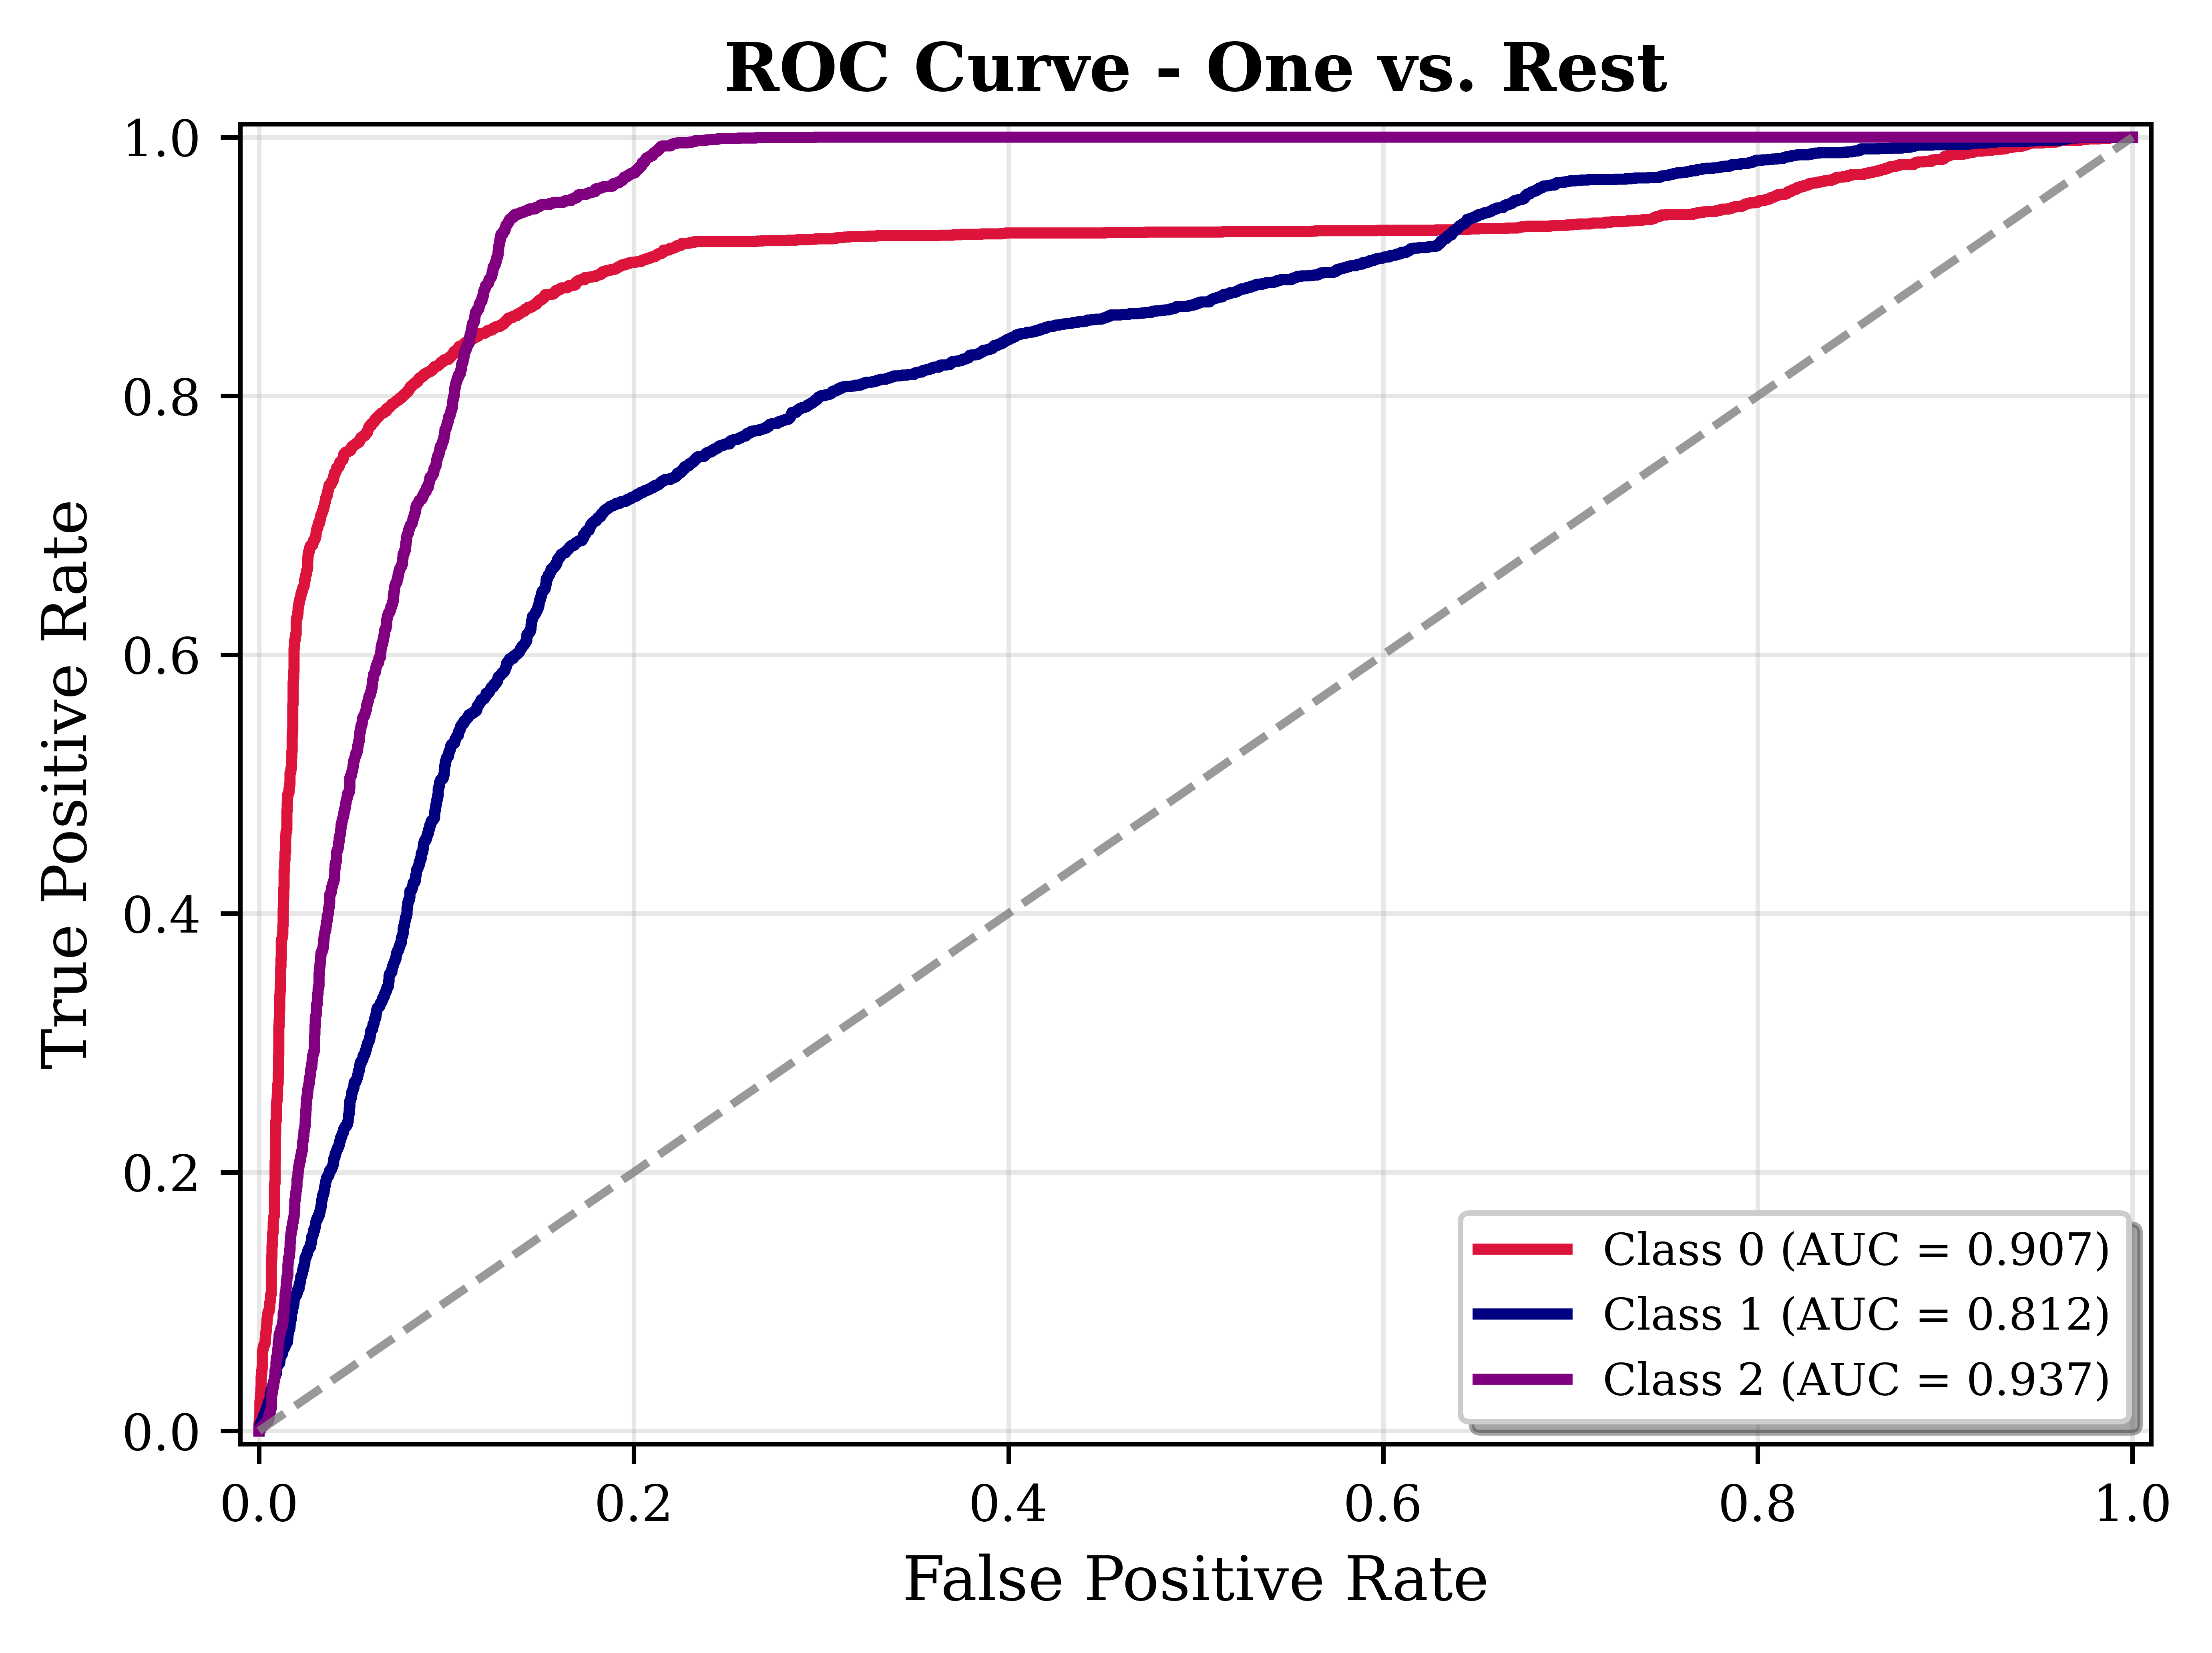

validation_loss: 0.9980, validation_accuracy: 76.86%



100%|██████████| 244/244 [00:25<00:00,  9.57it/s]


epoch [2/40], train_loss: 0.9306, train_accuracy: 72.87%, Time:25.49 seconds
validation_loss: 0.8704, validation_accuracy: 72.26%



100%|██████████| 244/244 [00:25<00:00,  9.40it/s]


epoch [3/40], train_loss: 0.8068, train_accuracy: 74.36%, Time:25.96 seconds
validation_loss: 0.7316, validation_accuracy: 78.59%



100%|██████████| 244/244 [00:25<00:00,  9.68it/s]


epoch [4/40], train_loss: 0.6893, train_accuracy: 77.42%, Time:25.21 seconds
validation_loss: 0.6470, validation_accuracy: 76.97%



100%|██████████| 244/244 [00:24<00:00,  9.84it/s]


epoch [5/40], train_loss: 0.5892, train_accuracy: 80.11%, Time:24.80 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9498
Class 1 AUC: 0.8256
Class 2 AUC: 0.9662


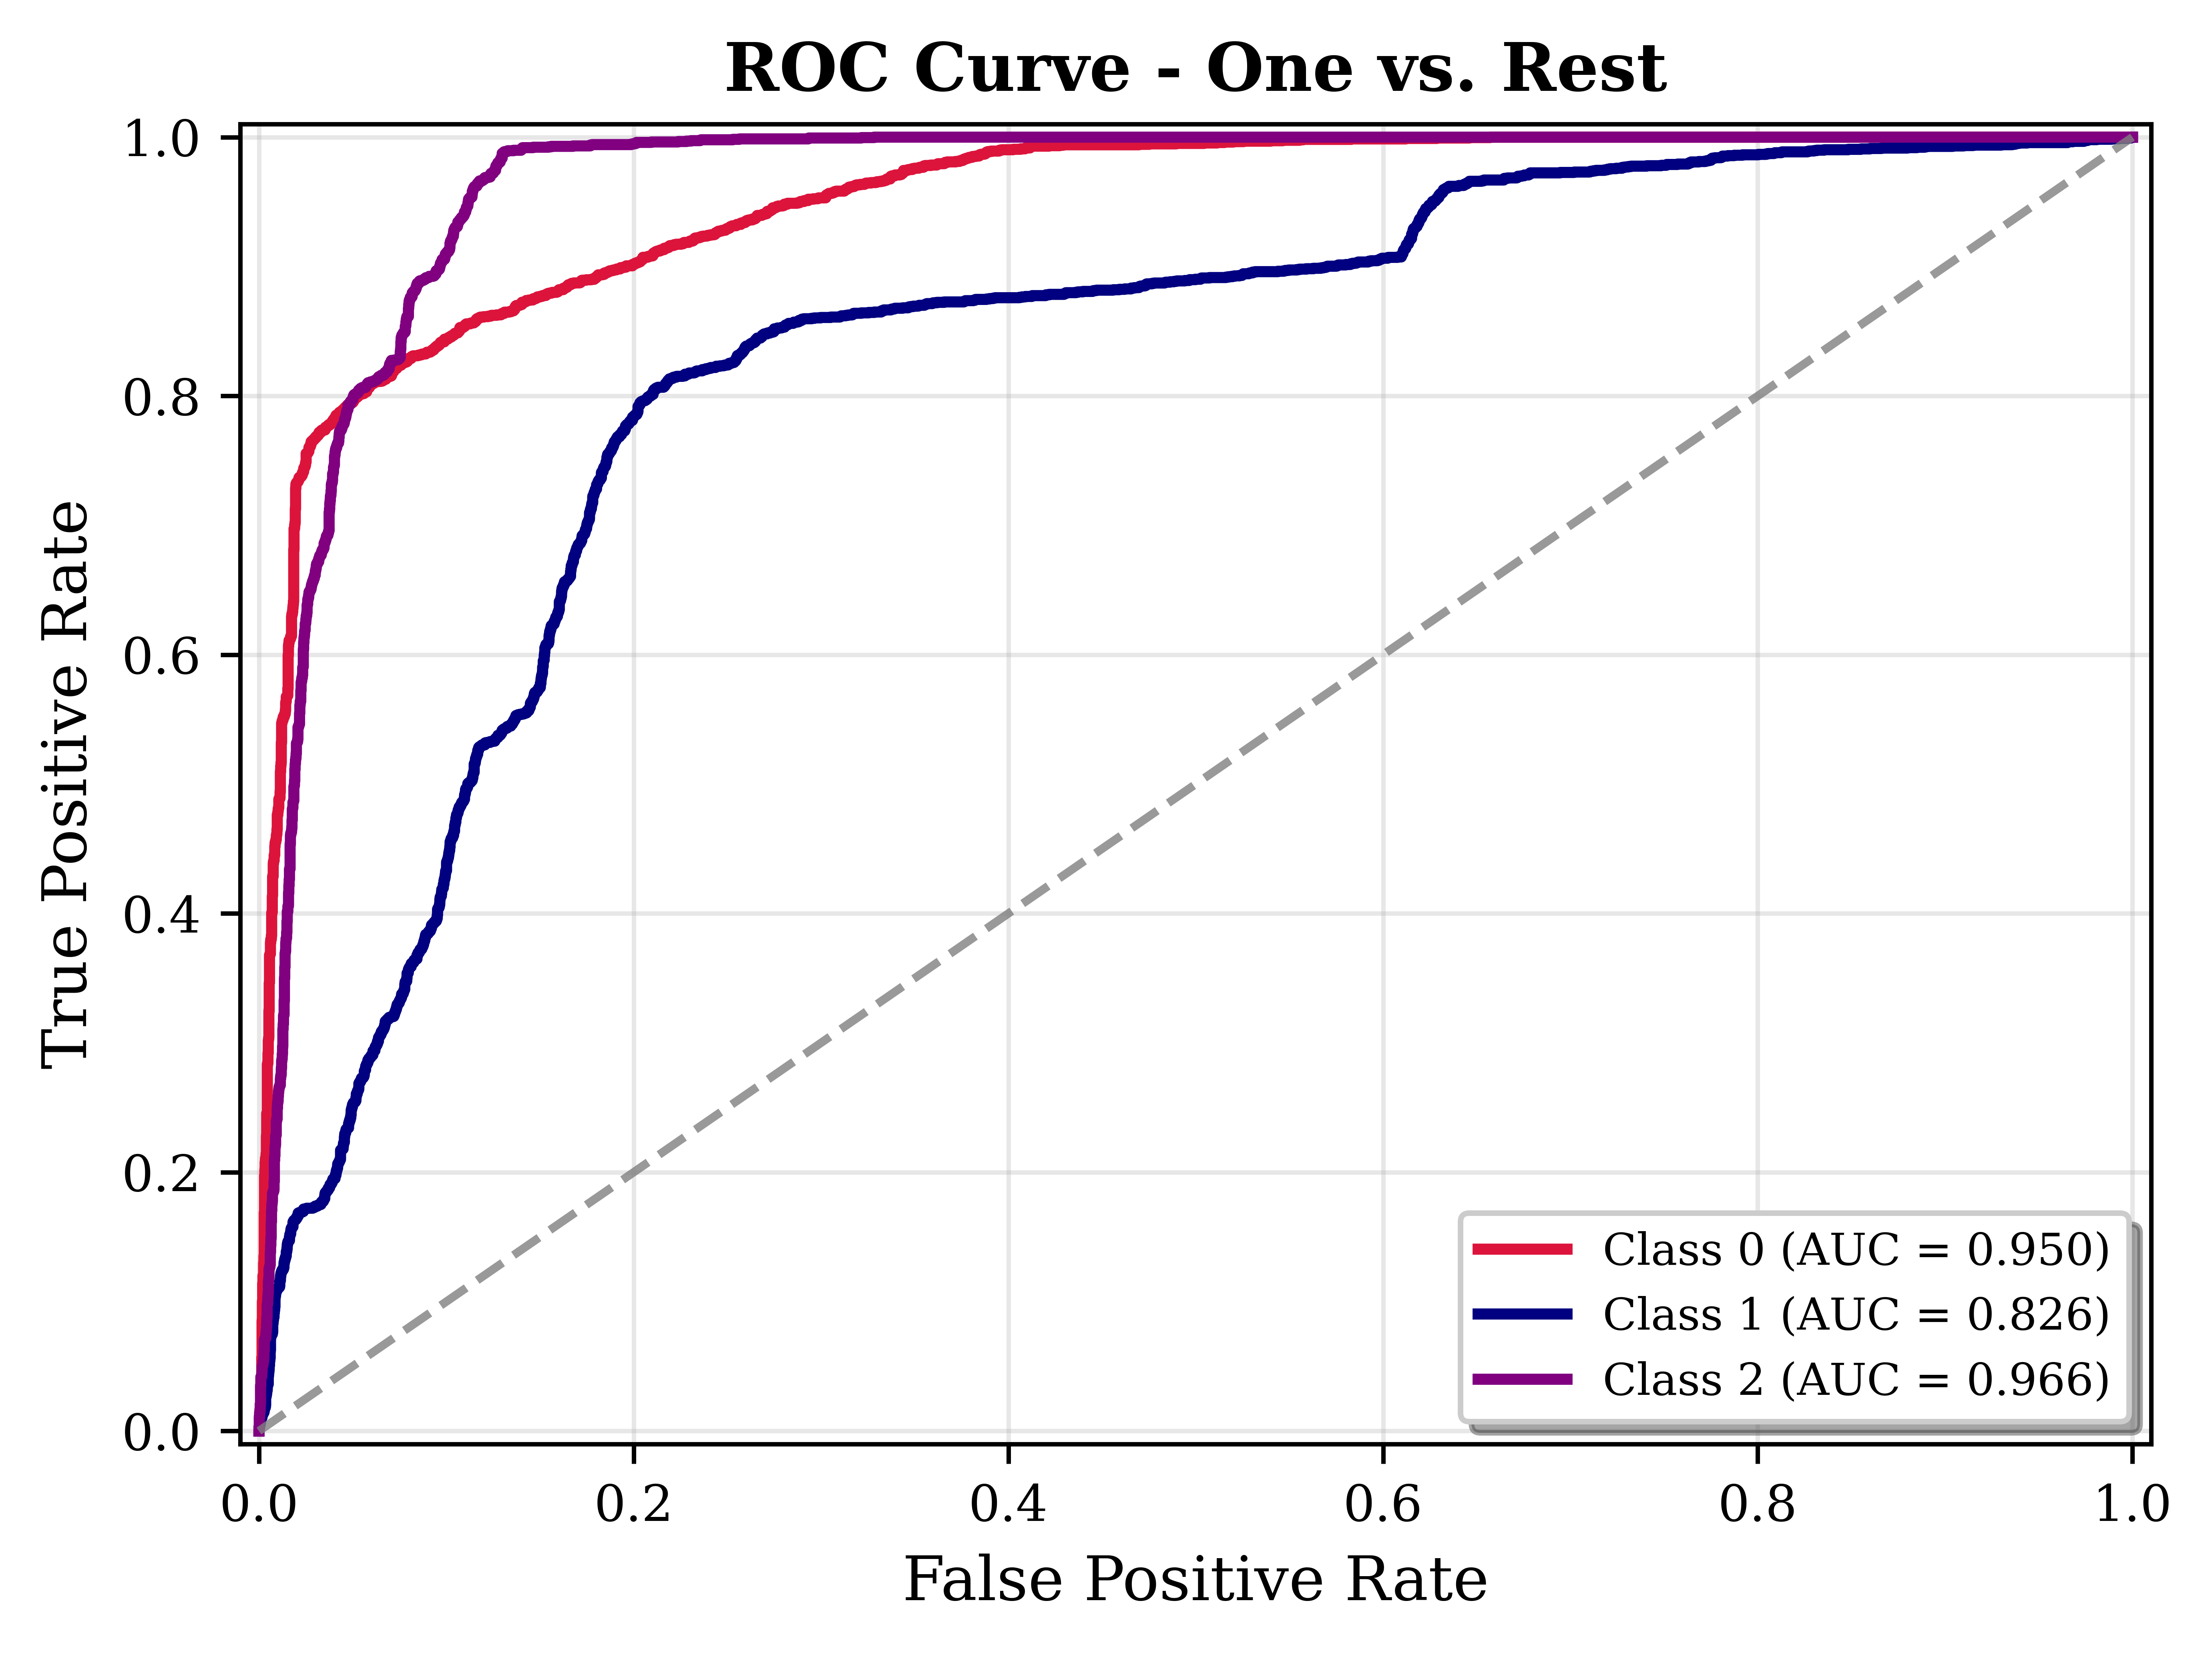

validation_loss: 0.5847, validation_accuracy: 76.31%



100%|██████████| 244/244 [00:25<00:00,  9.54it/s]


epoch [6/40], train_loss: 0.4972, train_accuracy: 83.13%, Time:25.59 seconds
validation_loss: 0.4614, validation_accuracy: 84.21%



100%|██████████| 244/244 [00:25<00:00,  9.55it/s]


epoch [7/40], train_loss: 0.4554, train_accuracy: 83.84%, Time:25.54 seconds
validation_loss: 0.4156, validation_accuracy: 86.15%



100%|██████████| 244/244 [00:25<00:00,  9.54it/s]


epoch [8/40], train_loss: 0.4027, train_accuracy: 85.42%, Time:25.57 seconds
validation_loss: 0.4164, validation_accuracy: 84.37%



100%|██████████| 244/244 [00:25<00:00,  9.43it/s]


epoch [9/40], train_loss: 0.3858, train_accuracy: 85.67%, Time:25.88 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9560
Class 1 AUC: 0.9012
Class 2 AUC: 0.9807


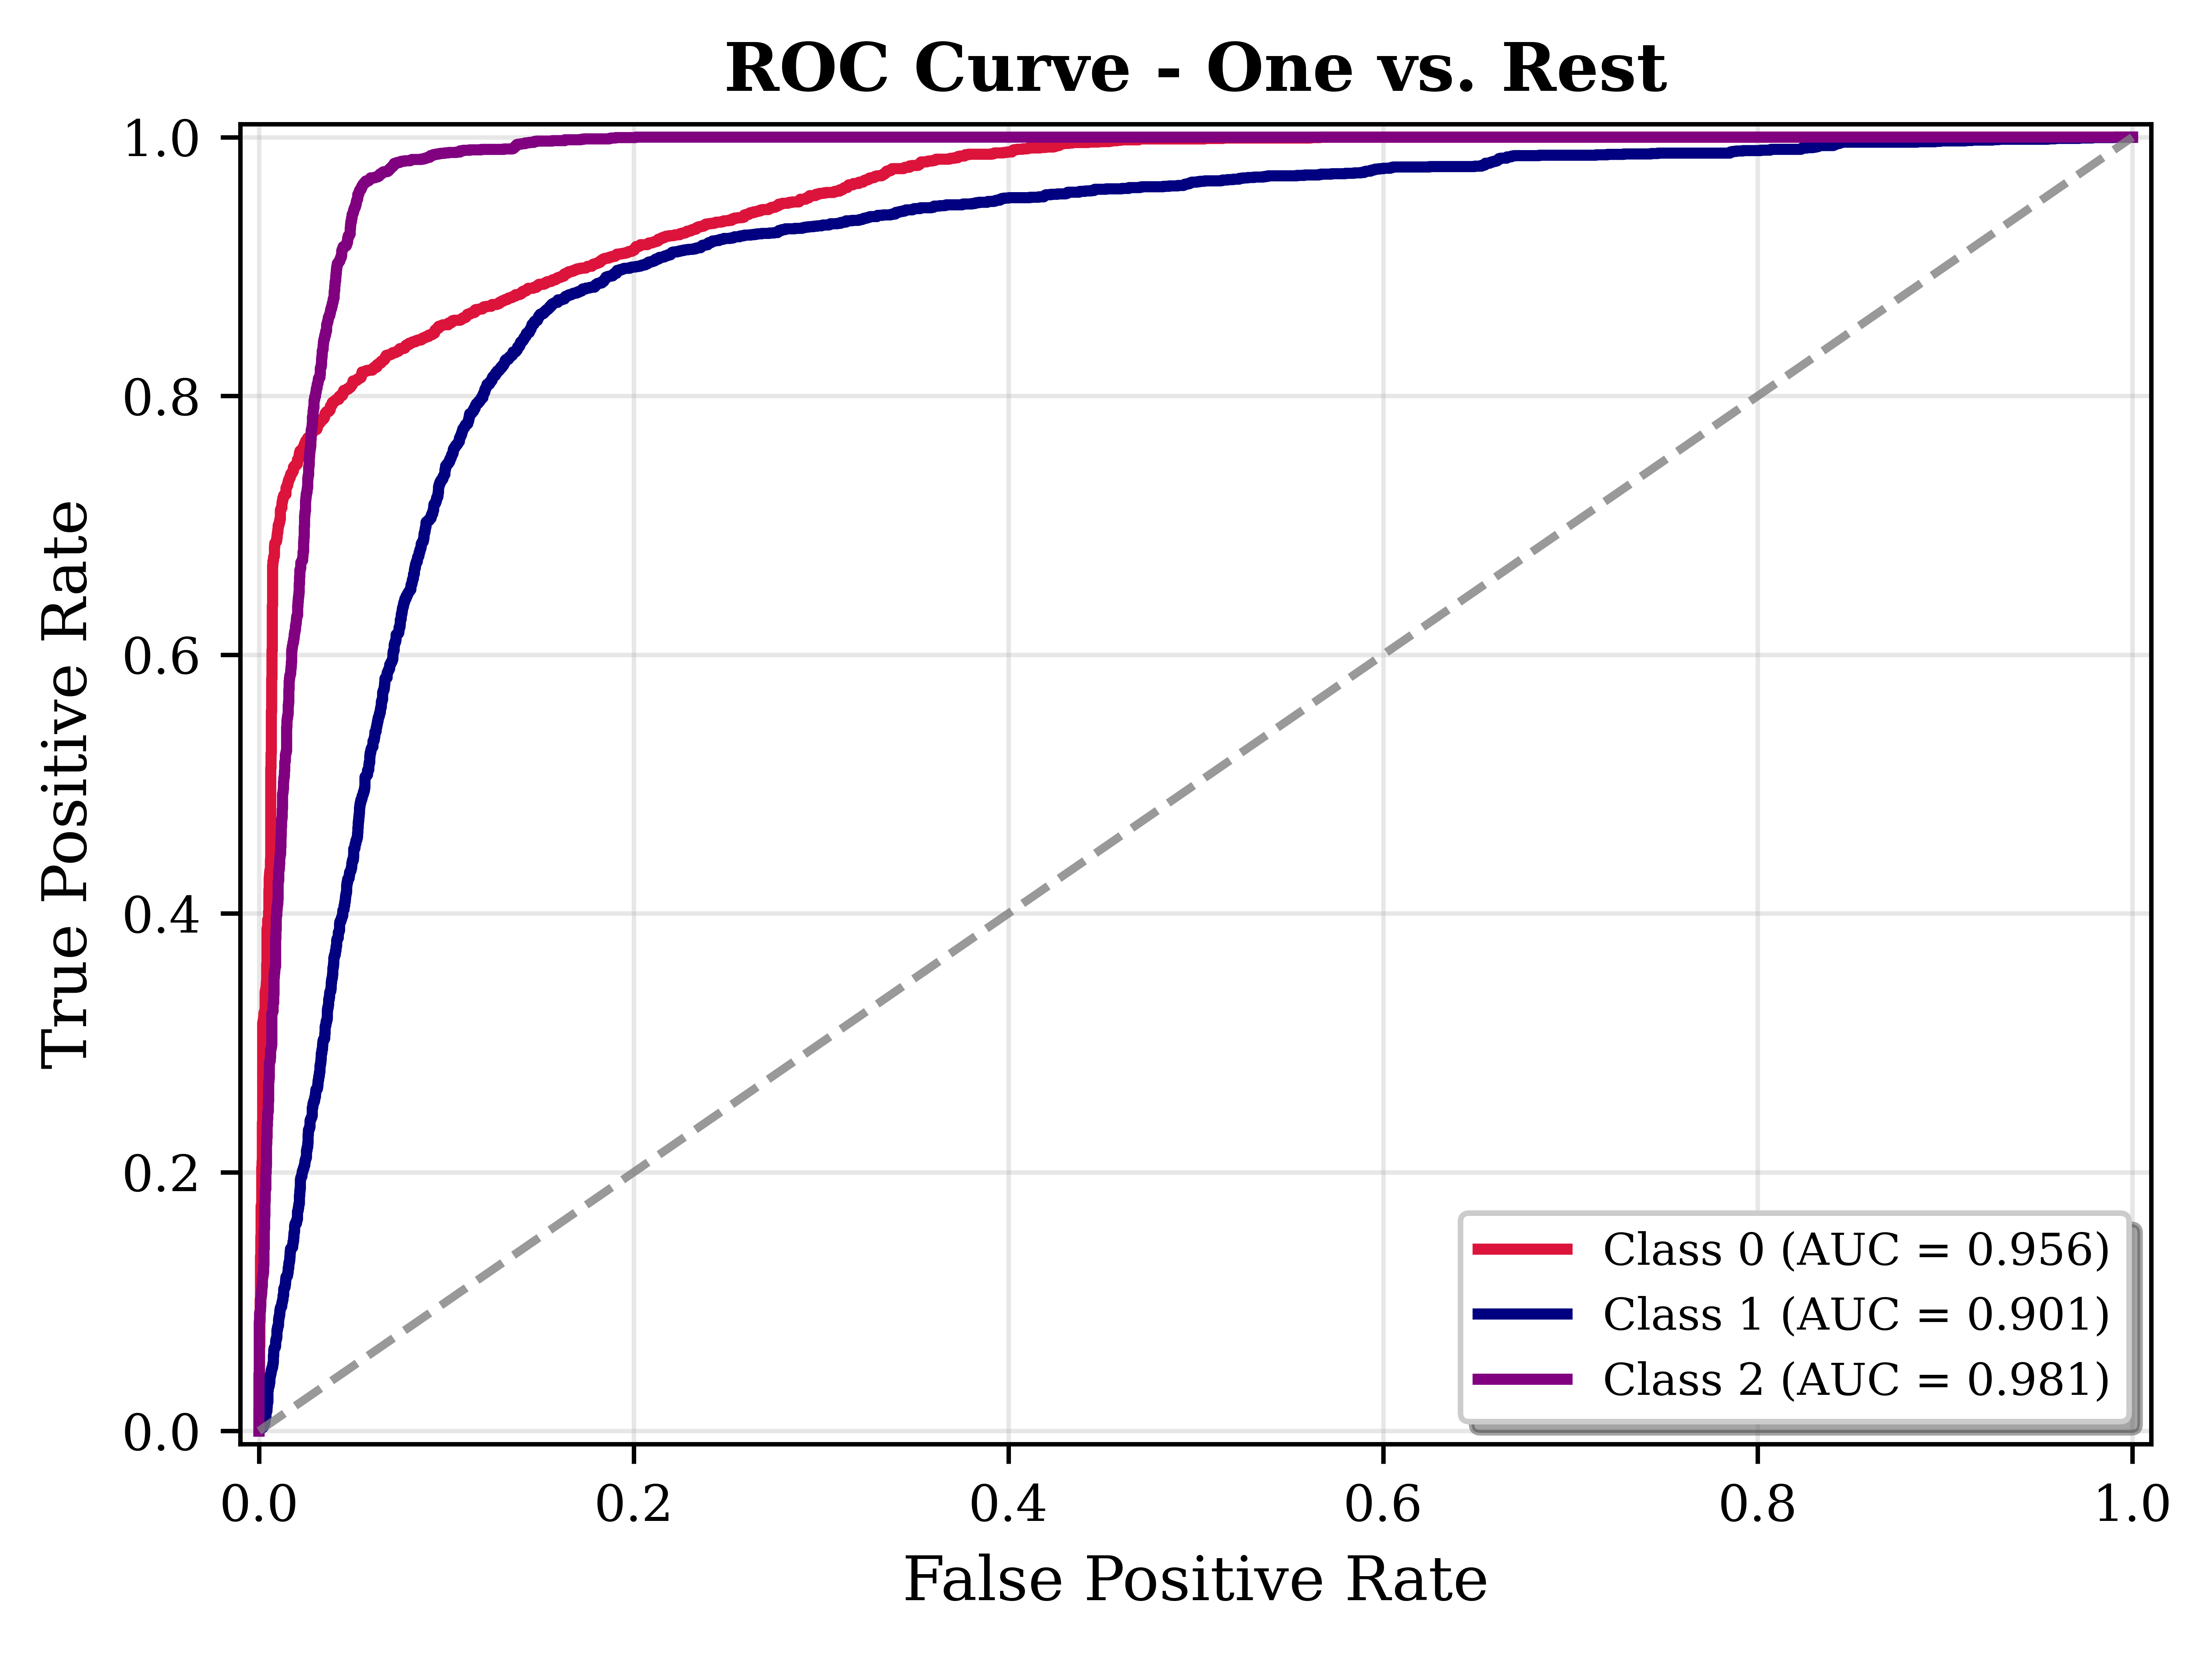

validation_loss: 0.4146, validation_accuracy: 84.64%



100%|██████████| 244/244 [00:25<00:00,  9.59it/s]


epoch [10/40], train_loss: 0.3750, train_accuracy: 85.83%, Time:25.45 seconds
validation_loss: 0.3674, validation_accuracy: 86.36%



100%|██████████| 244/244 [00:24<00:00,  9.83it/s]


epoch [11/40], train_loss: 0.3542, train_accuracy: 86.41%, Time:24.82 seconds
validation_loss: 0.3374, validation_accuracy: 87.10%



100%|██████████| 244/244 [00:25<00:00,  9.54it/s]


epoch [12/40], train_loss: 0.3366, train_accuracy: 87.06%, Time:25.57 seconds
validation_loss: 0.3058, validation_accuracy: 88.38%



100%|██████████| 244/244 [00:25<00:00,  9.50it/s]


epoch [13/40], train_loss: 0.3225, train_accuracy: 87.38%, Time:25.68 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9611
Class 1 AUC: 0.9276
Class 2 AUC: 0.9872


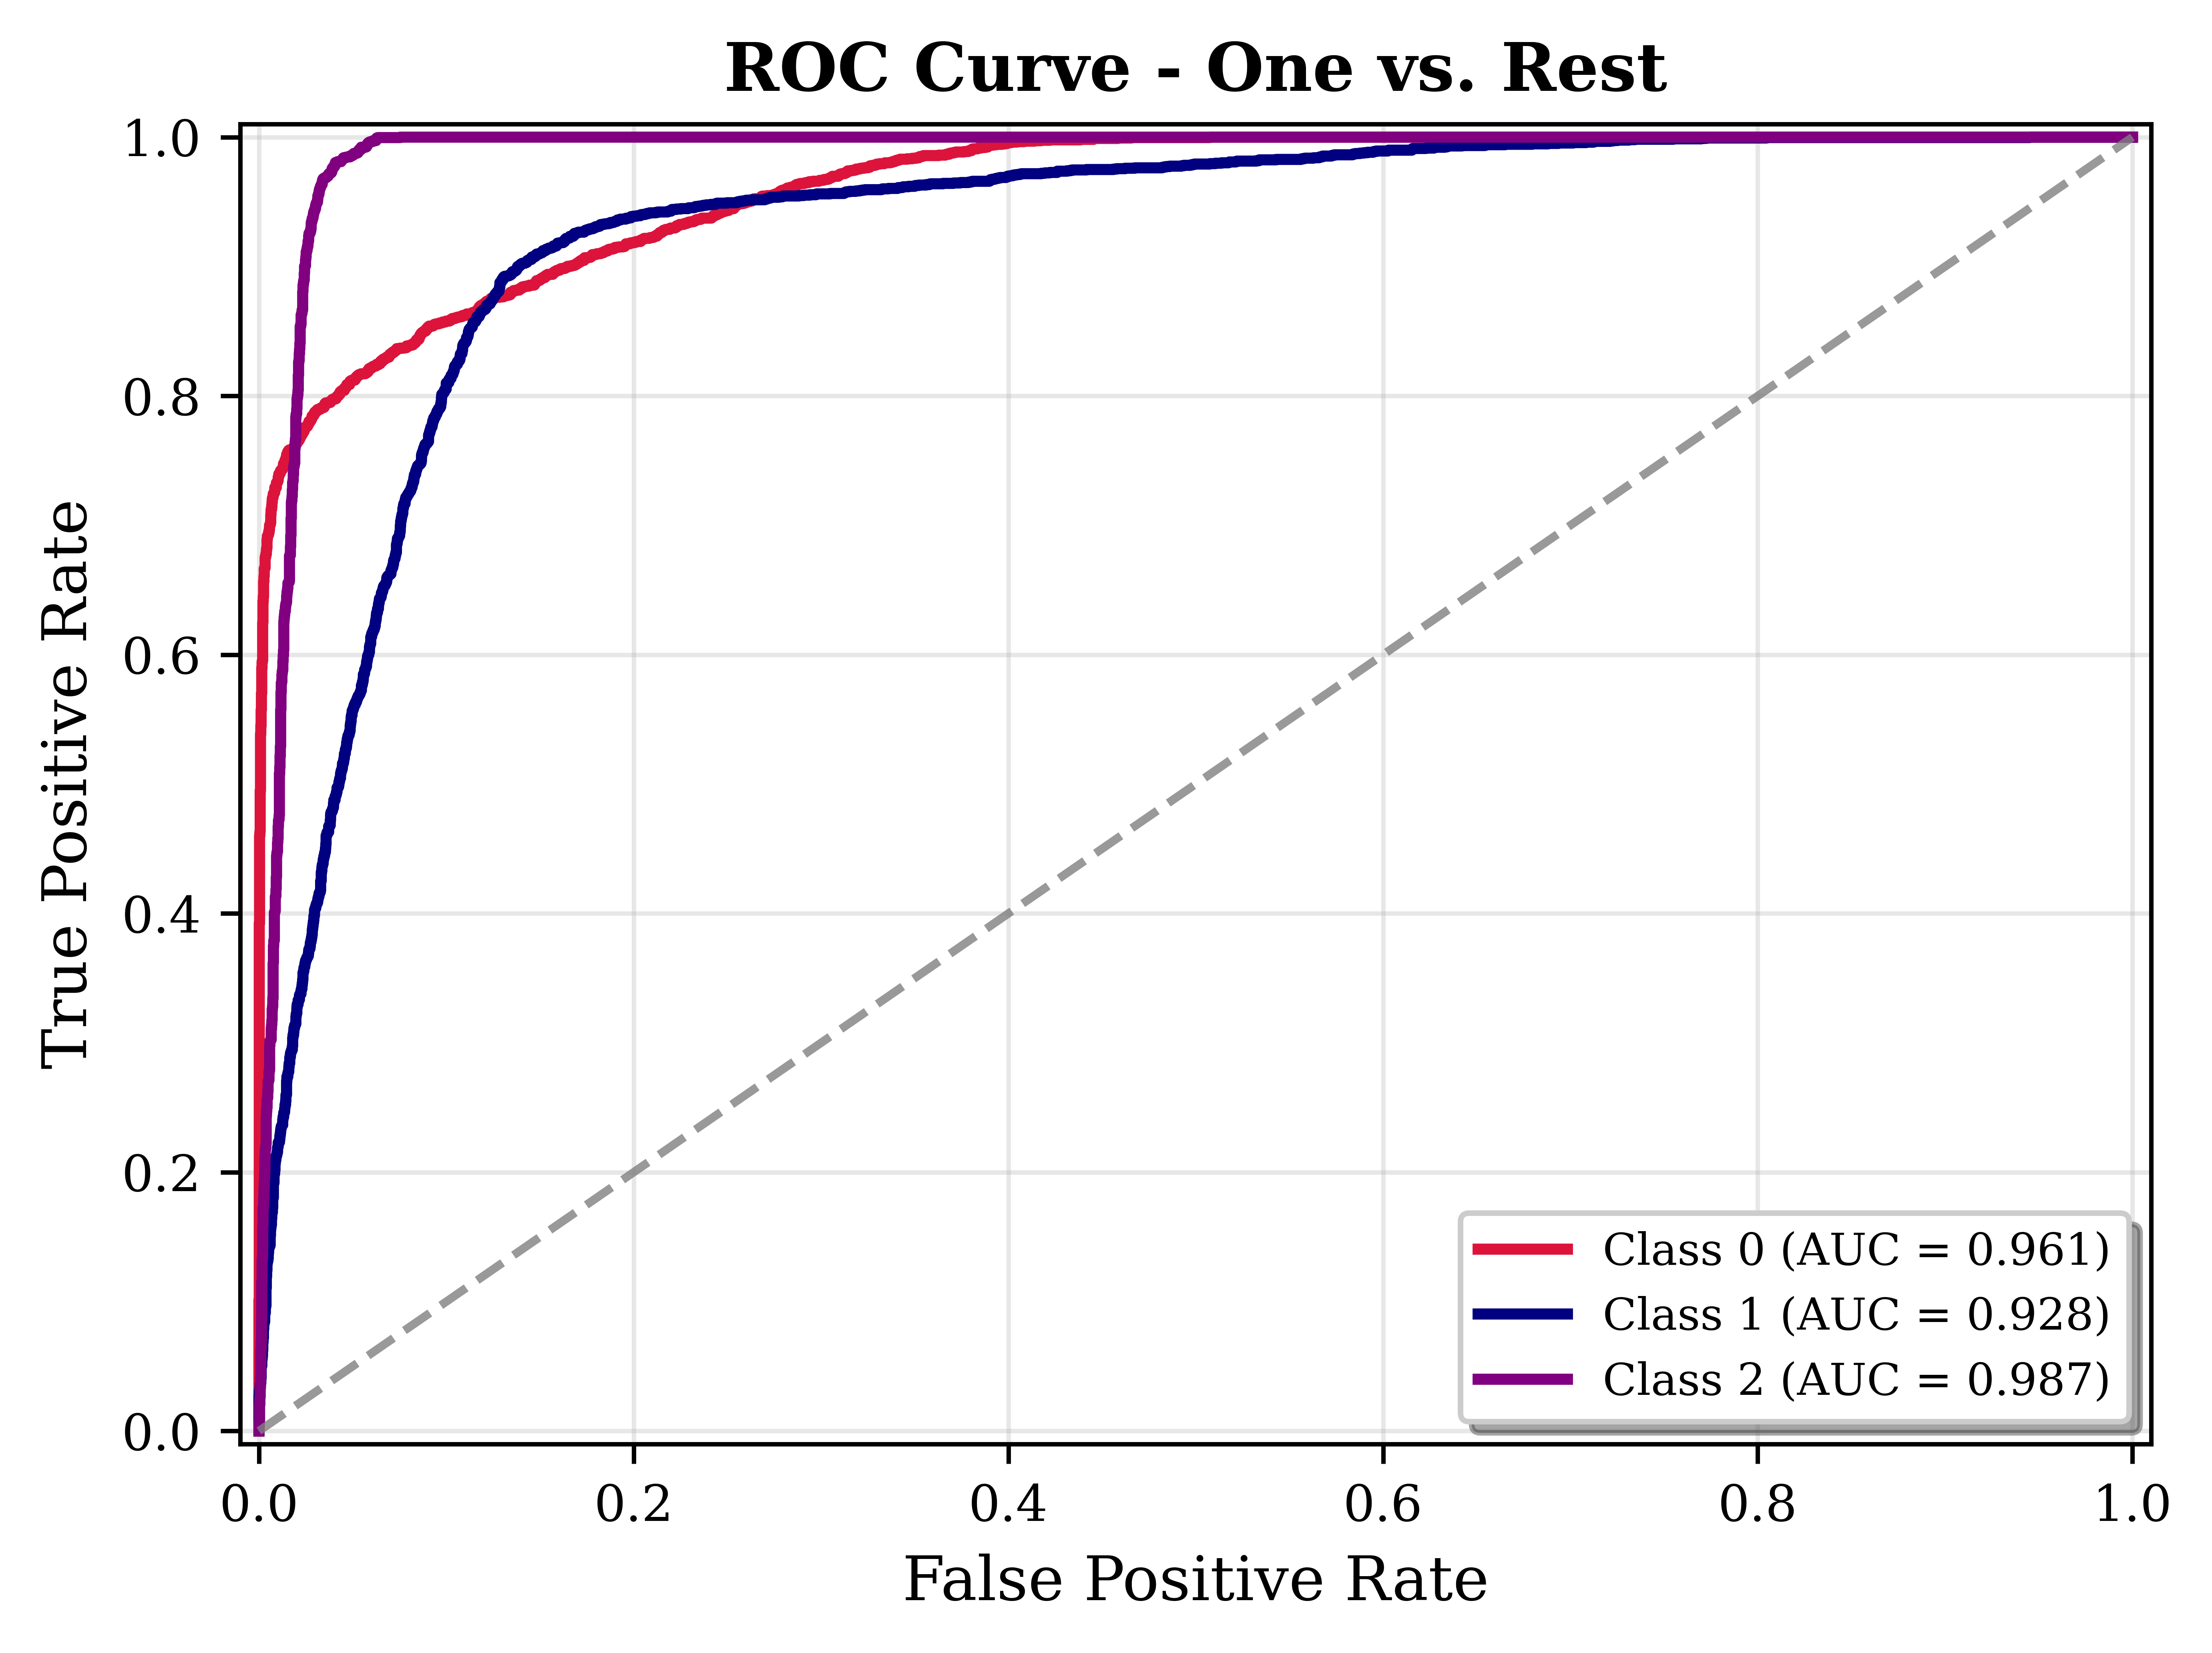

validation_loss: 0.3244, validation_accuracy: 87.59%



100%|██████████| 244/244 [00:25<00:00,  9.65it/s]


epoch [14/40], train_loss: 0.3149, train_accuracy: 87.62%, Time:25.29 seconds
validation_loss: 0.2832, validation_accuracy: 89.39%



100%|██████████| 244/244 [00:25<00:00,  9.64it/s]


epoch [15/40], train_loss: 0.2994, train_accuracy: 88.26%, Time:25.31 seconds
validation_loss: 0.3137, validation_accuracy: 87.52%



100%|██████████| 244/244 [00:24<00:00,  9.78it/s]


epoch [16/40], train_loss: 0.3069, train_accuracy: 87.76%, Time:24.96 seconds
validation_loss: 0.2933, validation_accuracy: 88.63%



100%|██████████| 244/244 [00:25<00:00,  9.54it/s]


epoch [17/40], train_loss: 0.2978, train_accuracy: 88.17%, Time:25.59 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9630
Class 1 AUC: 0.9482
Class 2 AUC: 0.9944


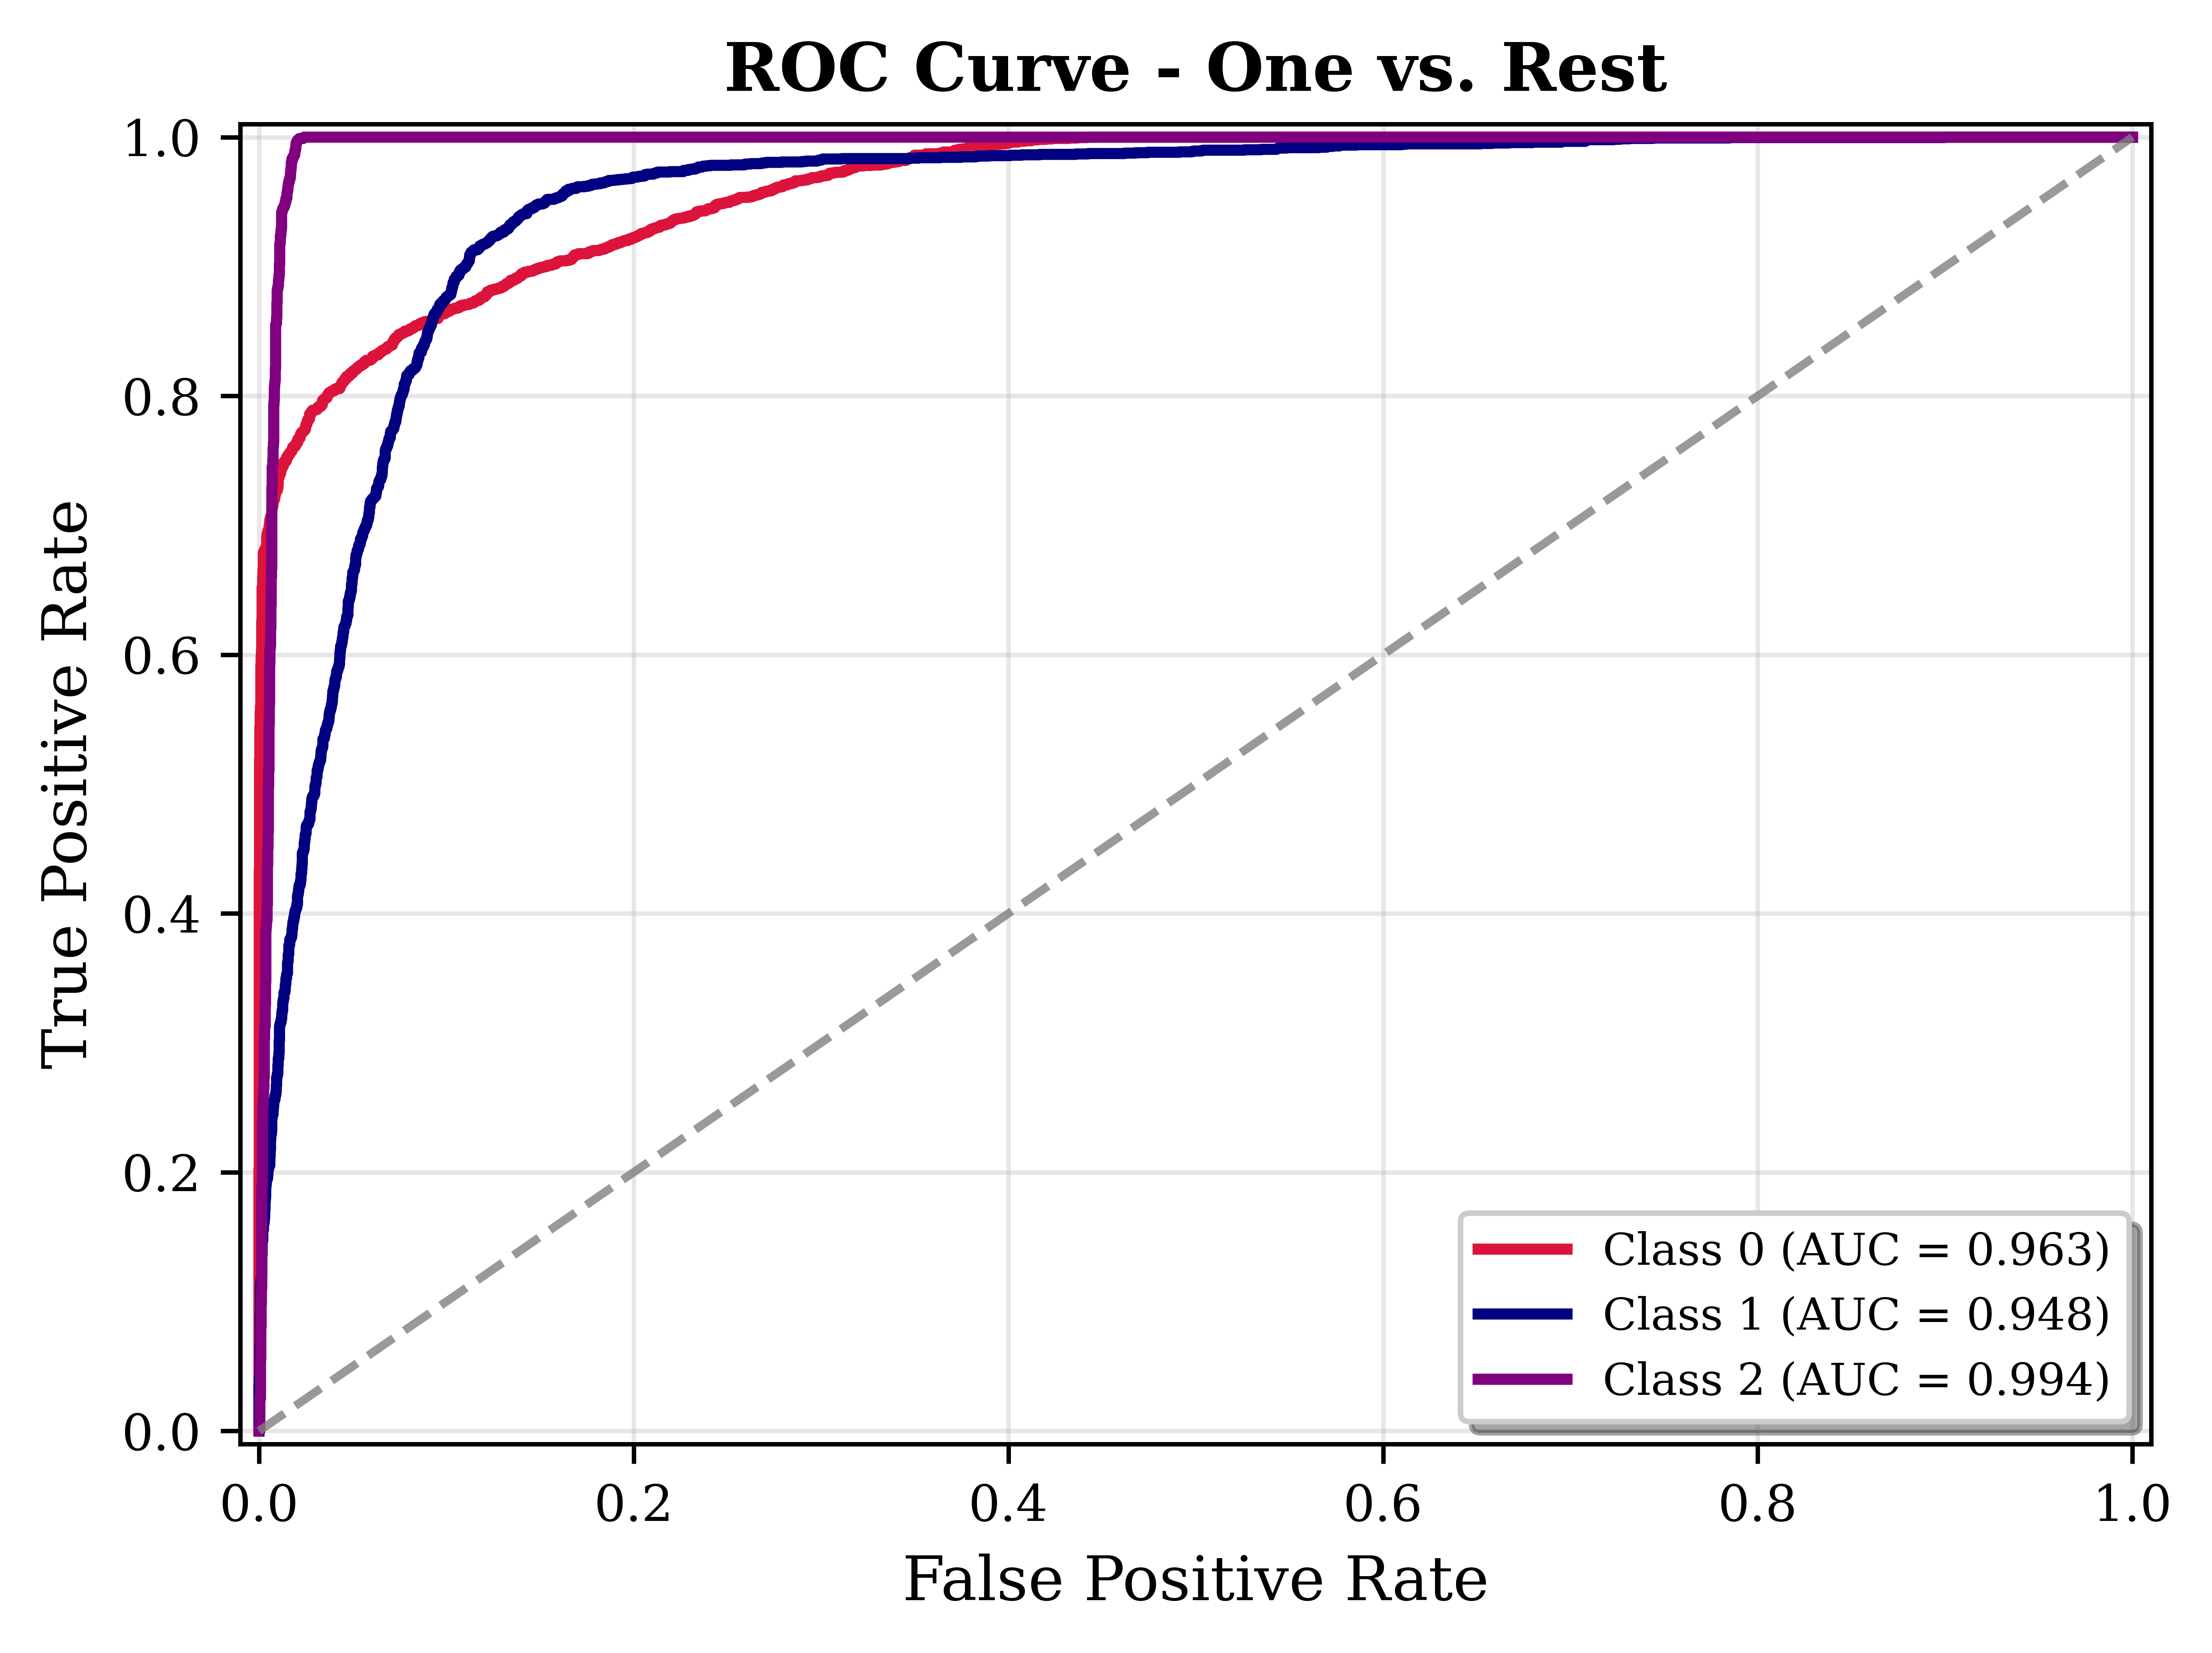

validation_loss: 0.2751, validation_accuracy: 88.97%



100%|██████████| 244/244 [00:25<00:00,  9.76it/s]


epoch [18/40], train_loss: 0.2854, train_accuracy: 88.54%, Time:25.01 seconds
validation_loss: 0.2669, validation_accuracy: 89.99%



100%|██████████| 244/244 [00:25<00:00,  9.55it/s]


epoch [19/40], train_loss: 0.2779, train_accuracy: 88.76%, Time:25.55 seconds
validation_loss: 0.2884, validation_accuracy: 88.86%



100%|██████████| 244/244 [00:25<00:00,  9.67it/s]


epoch [20/40], train_loss: 0.2899, train_accuracy: 88.44%, Time:25.23 seconds
validation_loss: 0.2690, validation_accuracy: 89.55%



100%|██████████| 244/244 [00:25<00:00,  9.46it/s]


epoch [21/40], train_loss: 0.2847, train_accuracy: 88.55%, Time:25.81 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9685
Class 1 AUC: 0.9572
Class 2 AUC: 0.9957


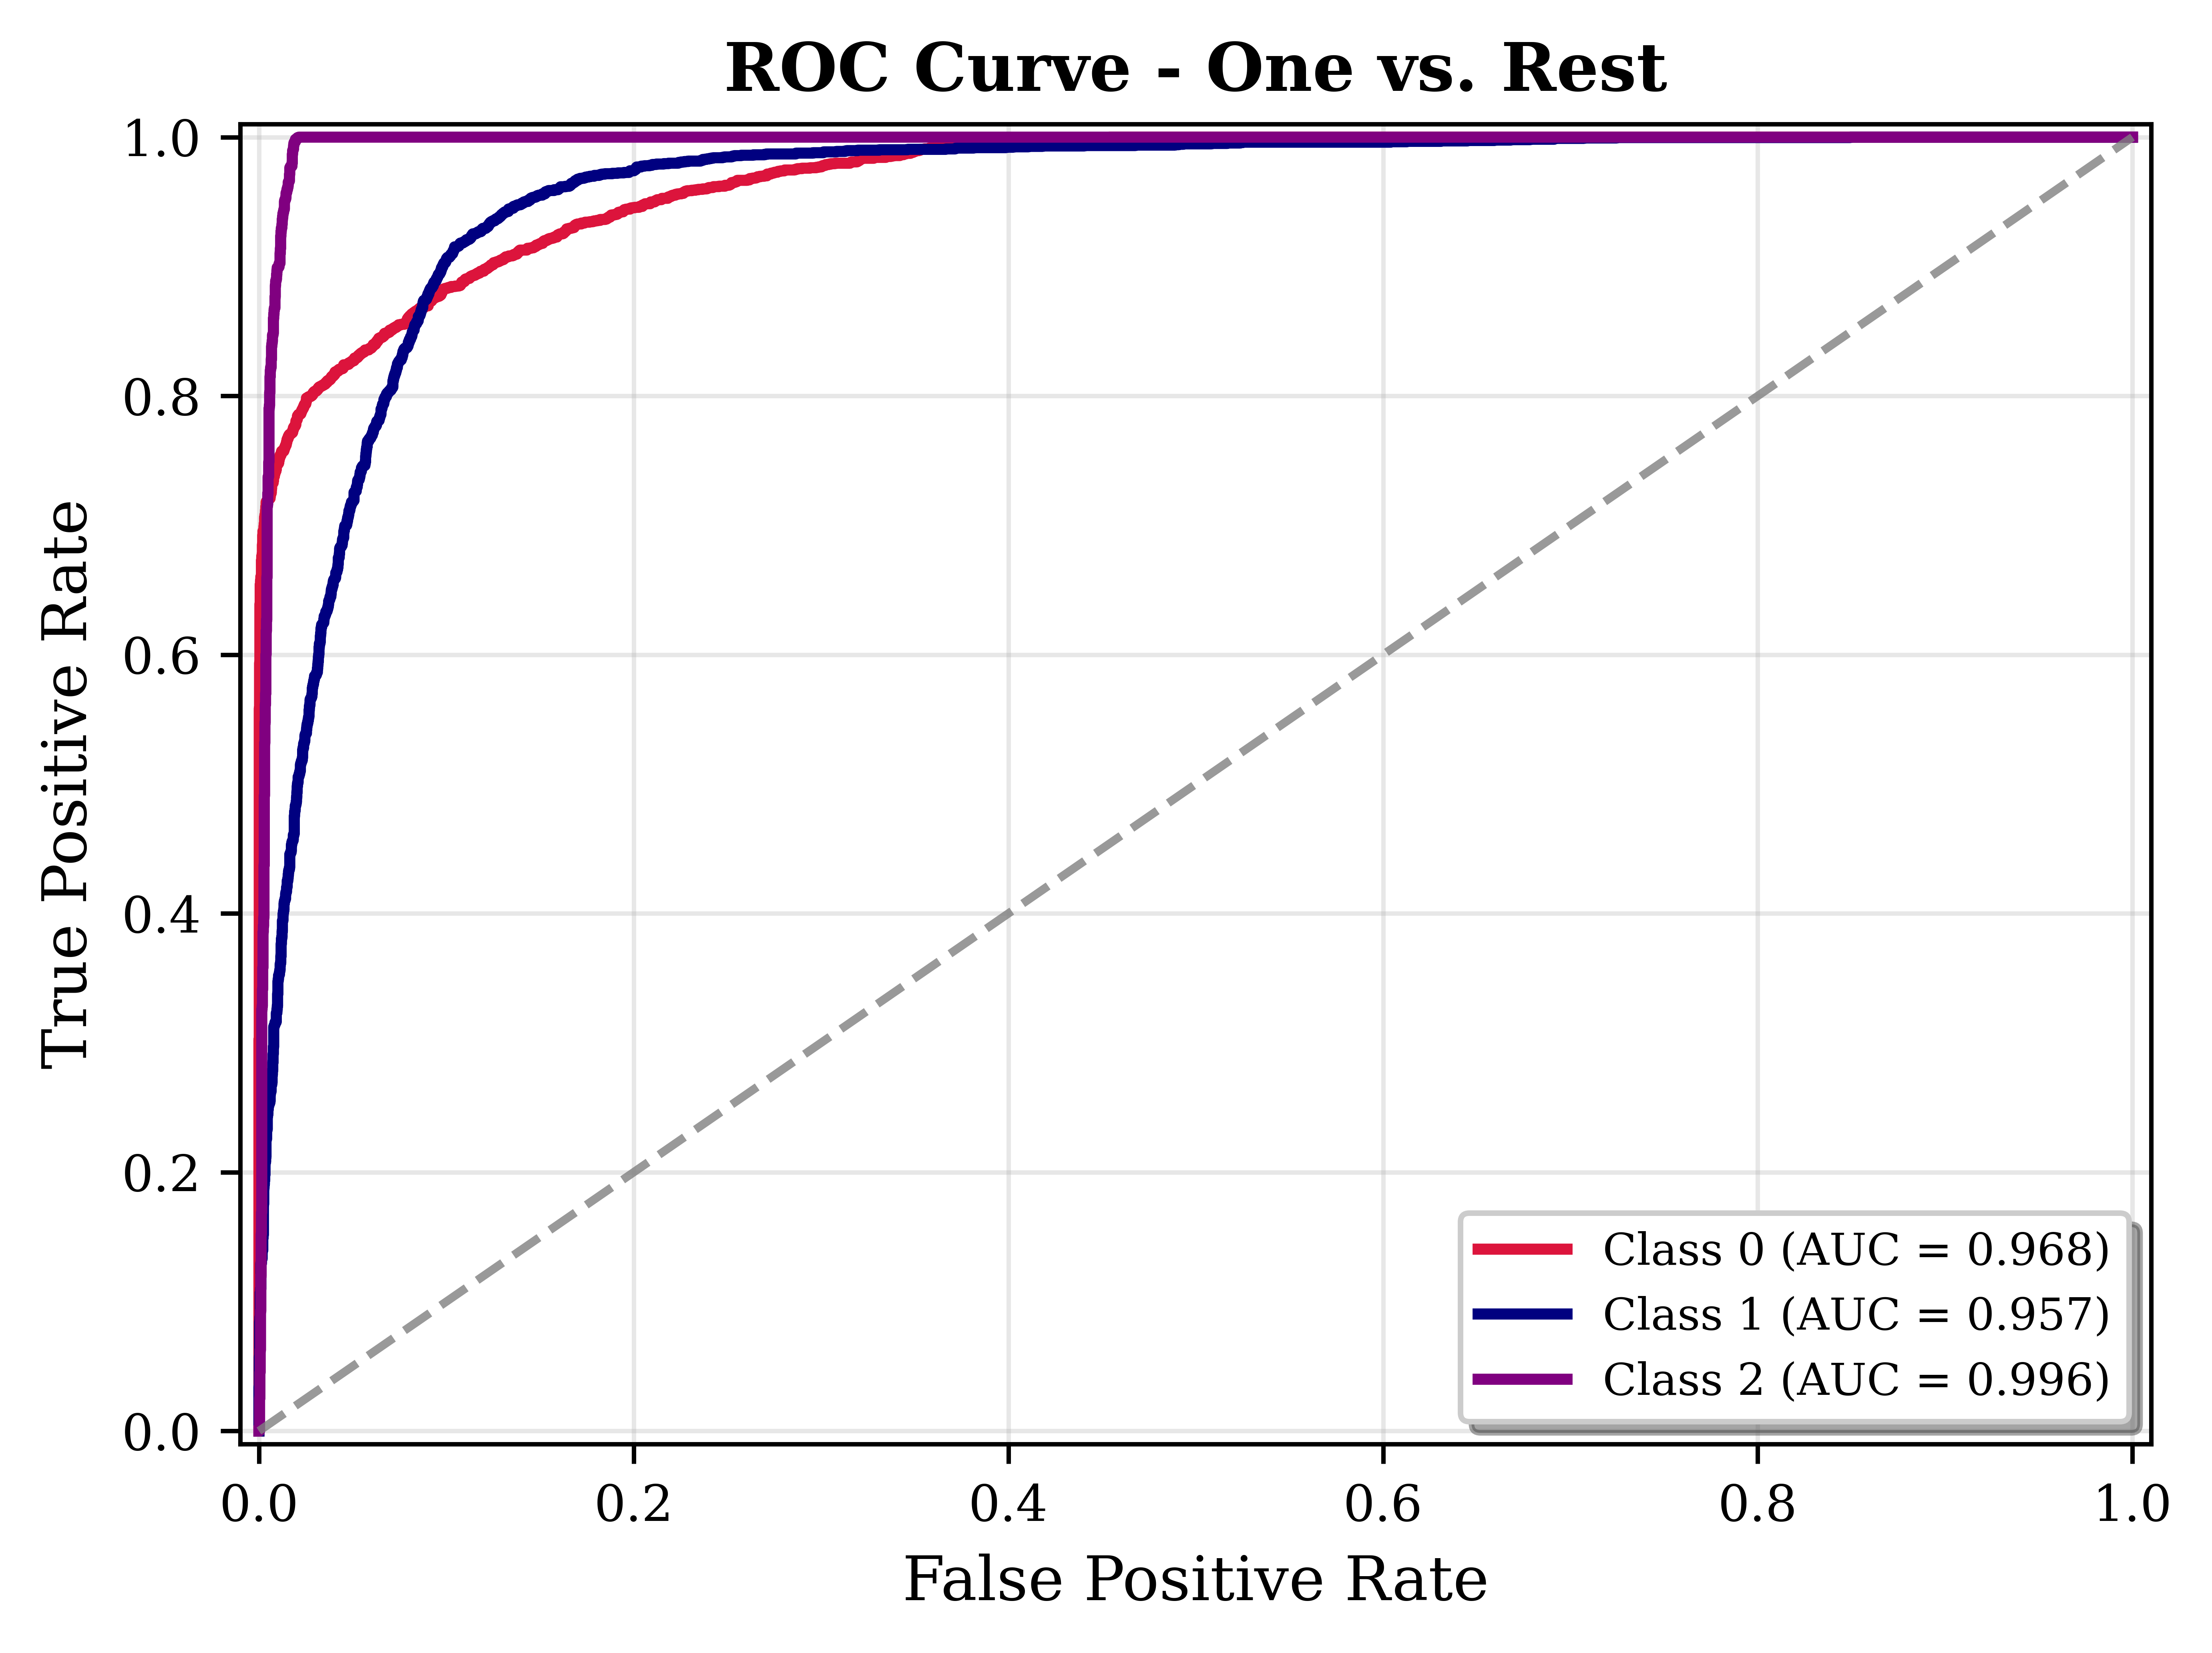

validation_loss: 0.2532, validation_accuracy: 89.51%



100%|██████████| 244/244 [00:24<00:00, 10.06it/s]


epoch [22/40], train_loss: 0.2607, train_accuracy: 89.35%, Time:24.26 seconds
validation_loss: 0.2689, validation_accuracy: 89.02%



100%|██████████| 244/244 [00:25<00:00,  9.49it/s]


epoch [23/40], train_loss: 0.2770, train_accuracy: 88.85%, Time:25.71 seconds
validation_loss: 0.2358, validation_accuracy: 90.70%



100%|██████████| 244/244 [00:25<00:00,  9.56it/s]


epoch [24/40], train_loss: 0.2542, train_accuracy: 89.55%, Time:25.52 seconds
validation_loss: 0.2502, validation_accuracy: 90.44%



100%|██████████| 244/244 [00:25<00:00,  9.52it/s]


epoch [25/40], train_loss: 0.2500, train_accuracy: 89.61%, Time:25.63 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9732
Class 1 AUC: 0.9673
Class 2 AUC: 0.9972


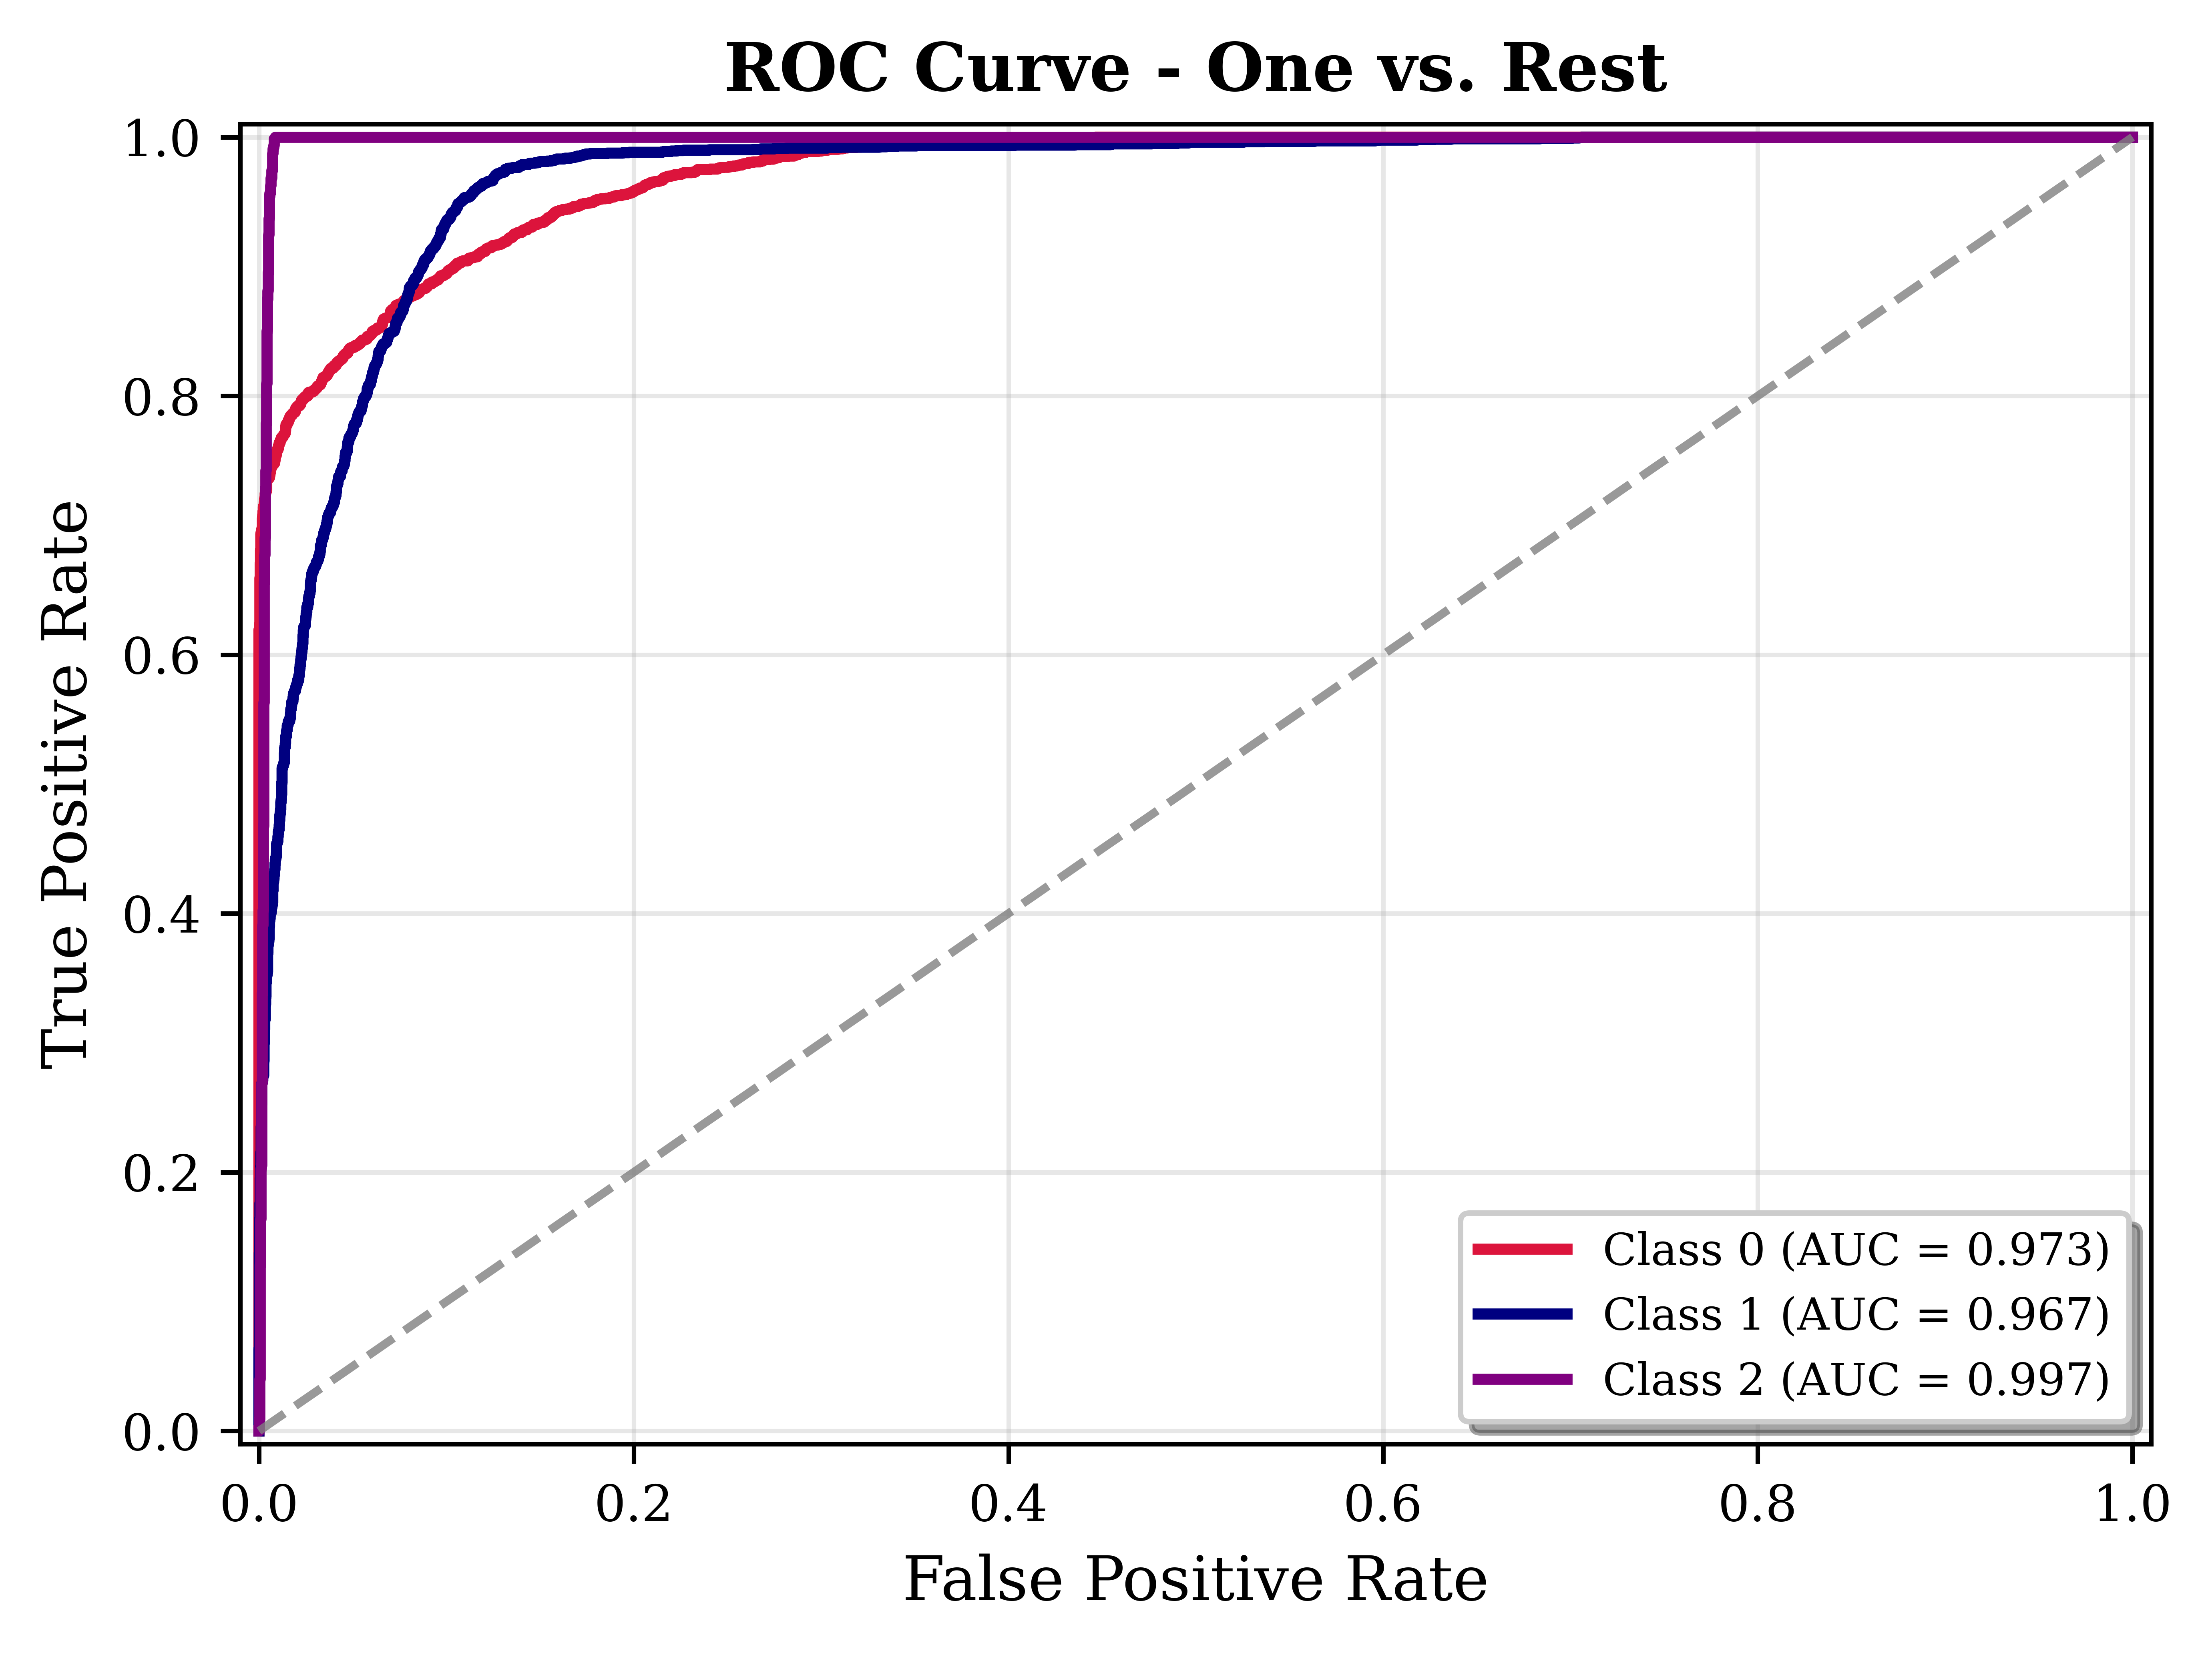

validation_loss: 0.2165, validation_accuracy: 91.20%



100%|██████████| 244/244 [00:25<00:00,  9.54it/s]


epoch [26/40], train_loss: 0.2516, train_accuracy: 89.58%, Time:25.59 seconds
validation_loss: 0.2489, validation_accuracy: 90.16%



100%|██████████| 244/244 [00:25<00:00,  9.65it/s]


epoch [27/40], train_loss: 0.2411, train_accuracy: 89.92%, Time:25.29 seconds
validation_loss: 0.2114, validation_accuracy: 91.23%



100%|██████████| 244/244 [00:24<00:00,  9.88it/s]


epoch [28/40], train_loss: 0.2354, train_accuracy: 90.18%, Time:24.69 seconds
validation_loss: 0.2407, validation_accuracy: 90.19%



100%|██████████| 244/244 [00:25<00:00,  9.50it/s]


epoch [29/40], train_loss: 0.2348, train_accuracy: 90.10%, Time:25.68 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9793
Class 1 AUC: 0.9654
Class 2 AUC: 0.9932


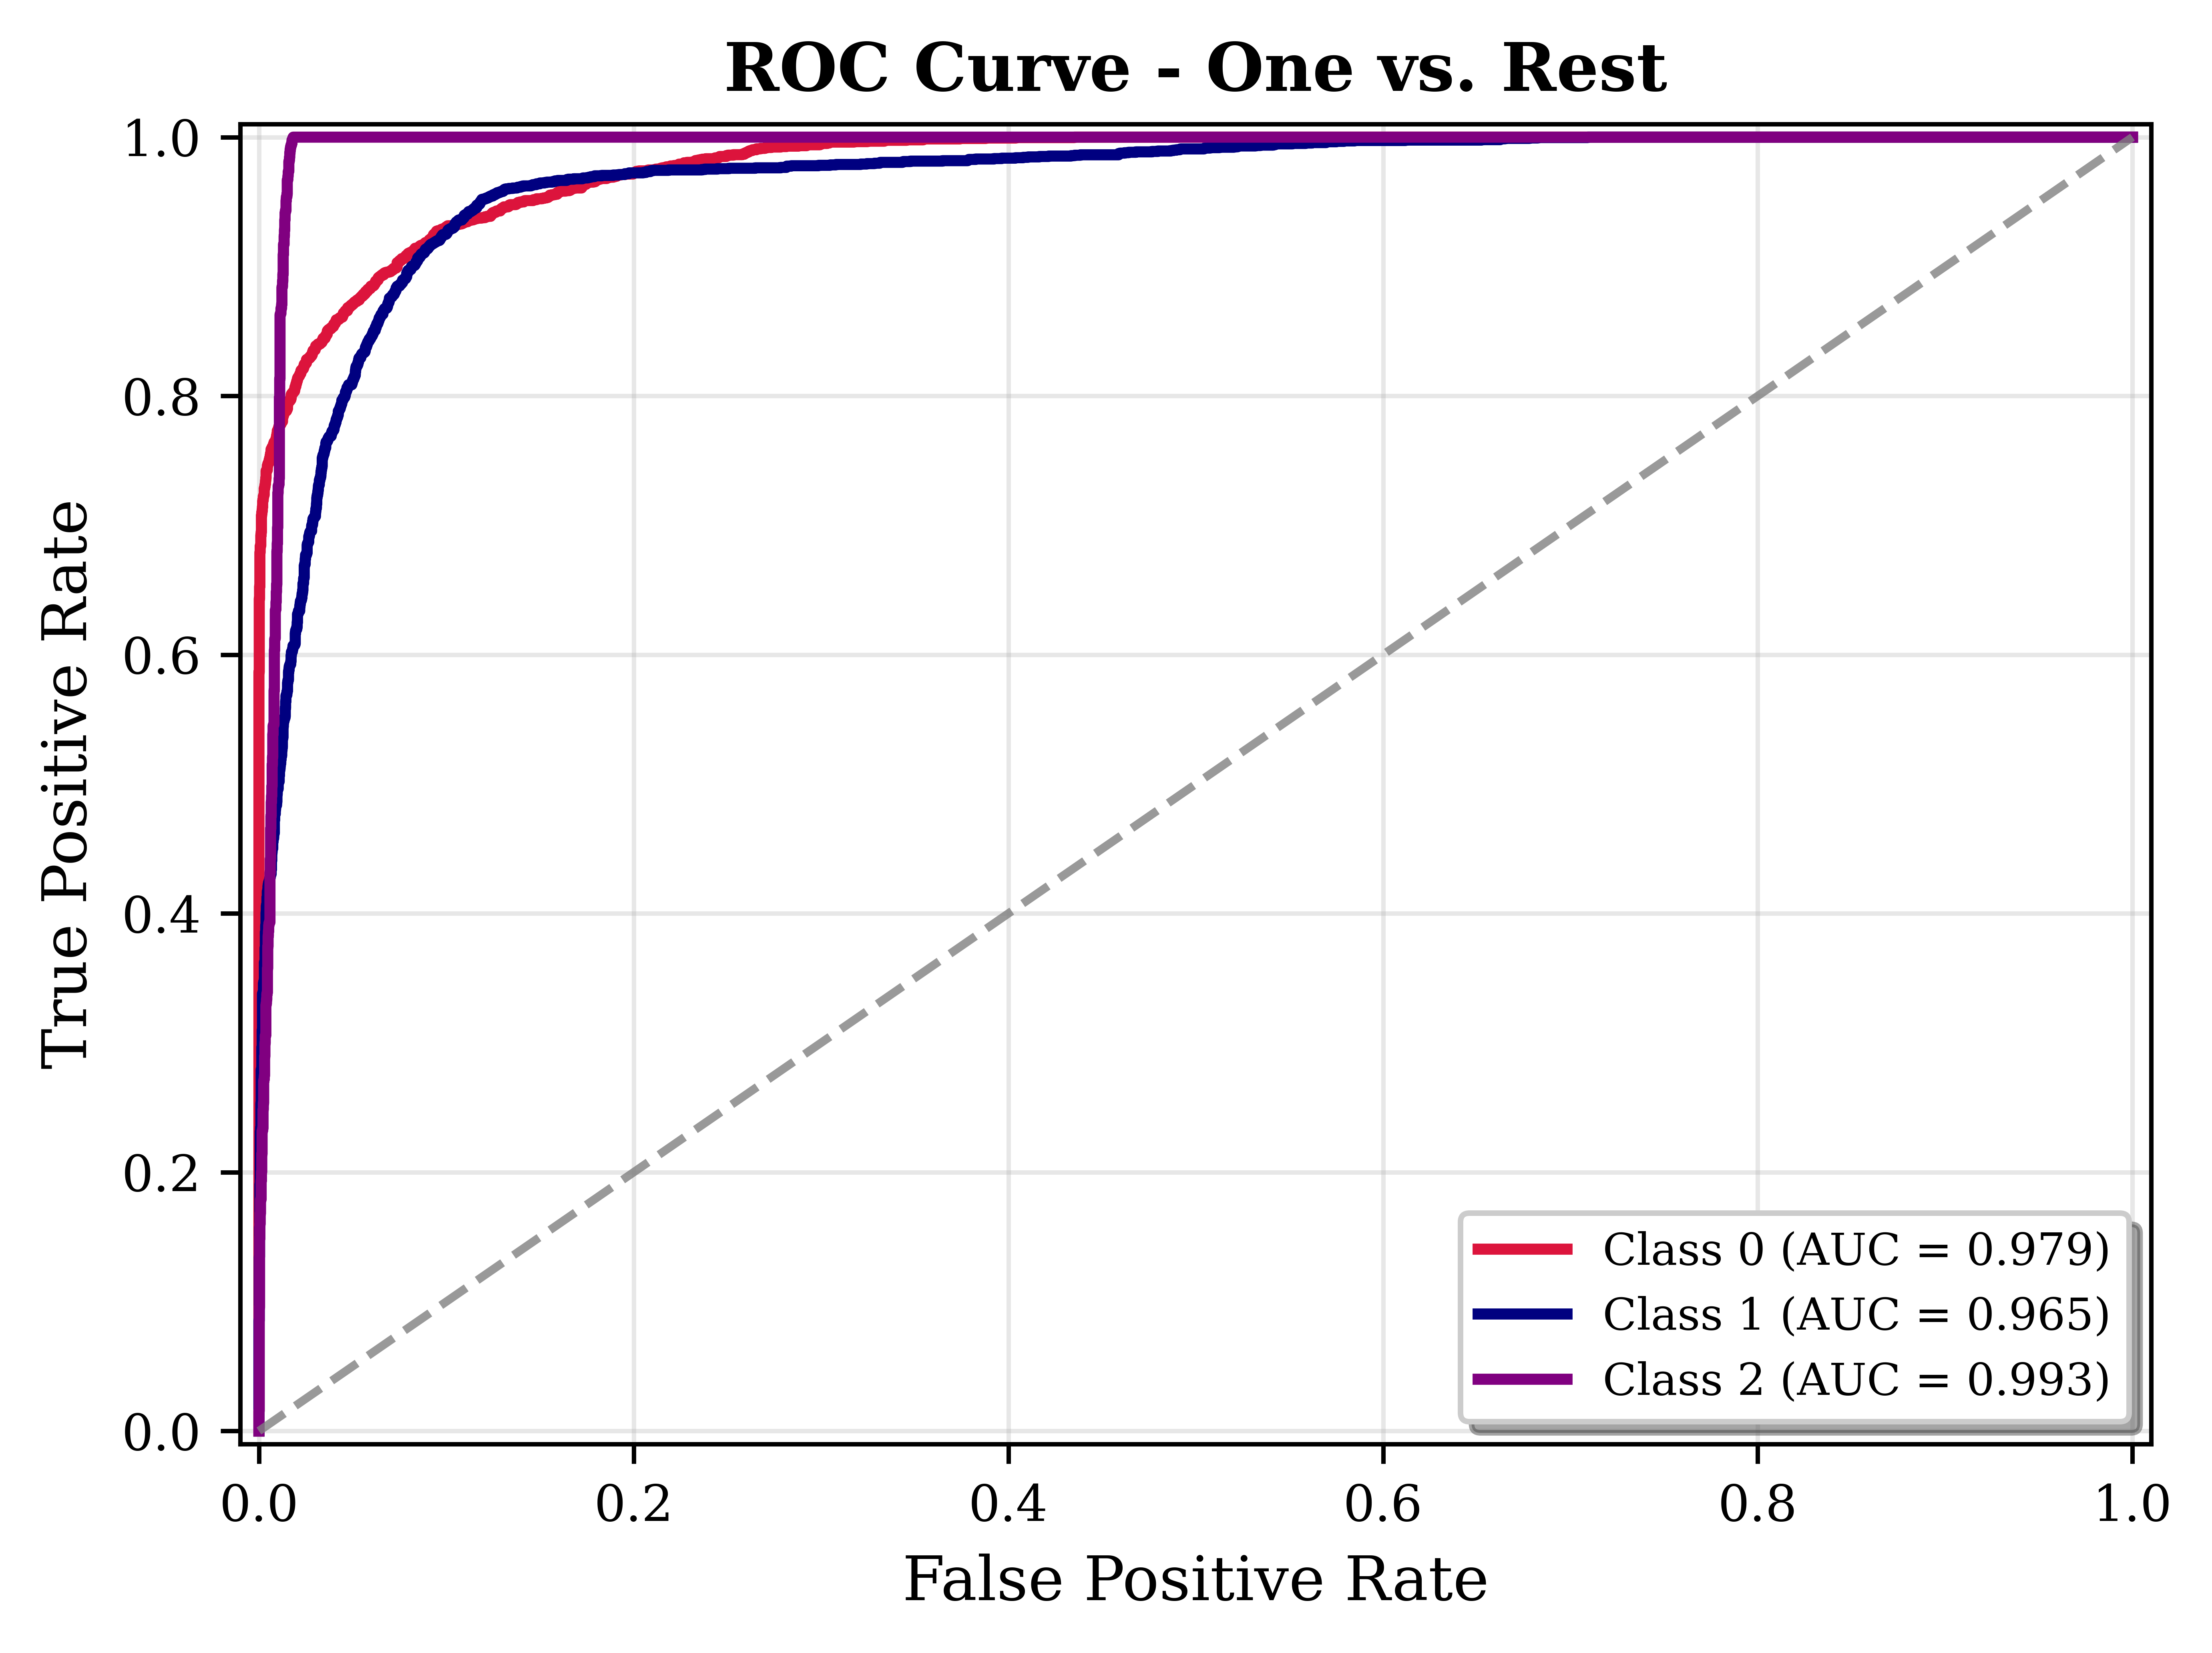

validation_loss: 0.2357, validation_accuracy: 90.51%



100%|██████████| 244/244 [00:25<00:00,  9.59it/s]


epoch [30/40], train_loss: 0.2241, train_accuracy: 90.65%, Time:25.45 seconds
validation_loss: 0.2011, validation_accuracy: 91.62%



100%|██████████| 244/244 [00:25<00:00,  9.54it/s]


epoch [31/40], train_loss: 0.2226, train_accuracy: 90.79%, Time:25.58 seconds
validation_loss: 0.1808, validation_accuracy: 92.01%



100%|██████████| 244/244 [00:25<00:00,  9.41it/s]


epoch [32/40], train_loss: 0.2014, train_accuracy: 91.45%, Time:25.92 seconds
validation_loss: 0.1932, validation_accuracy: 91.55%



100%|██████████| 244/244 [00:24<00:00,  9.90it/s]


epoch [33/40], train_loss: 0.2098, train_accuracy: 91.13%, Time:24.64 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9866
Class 1 AUC: 0.9790
Class 2 AUC: 0.9970


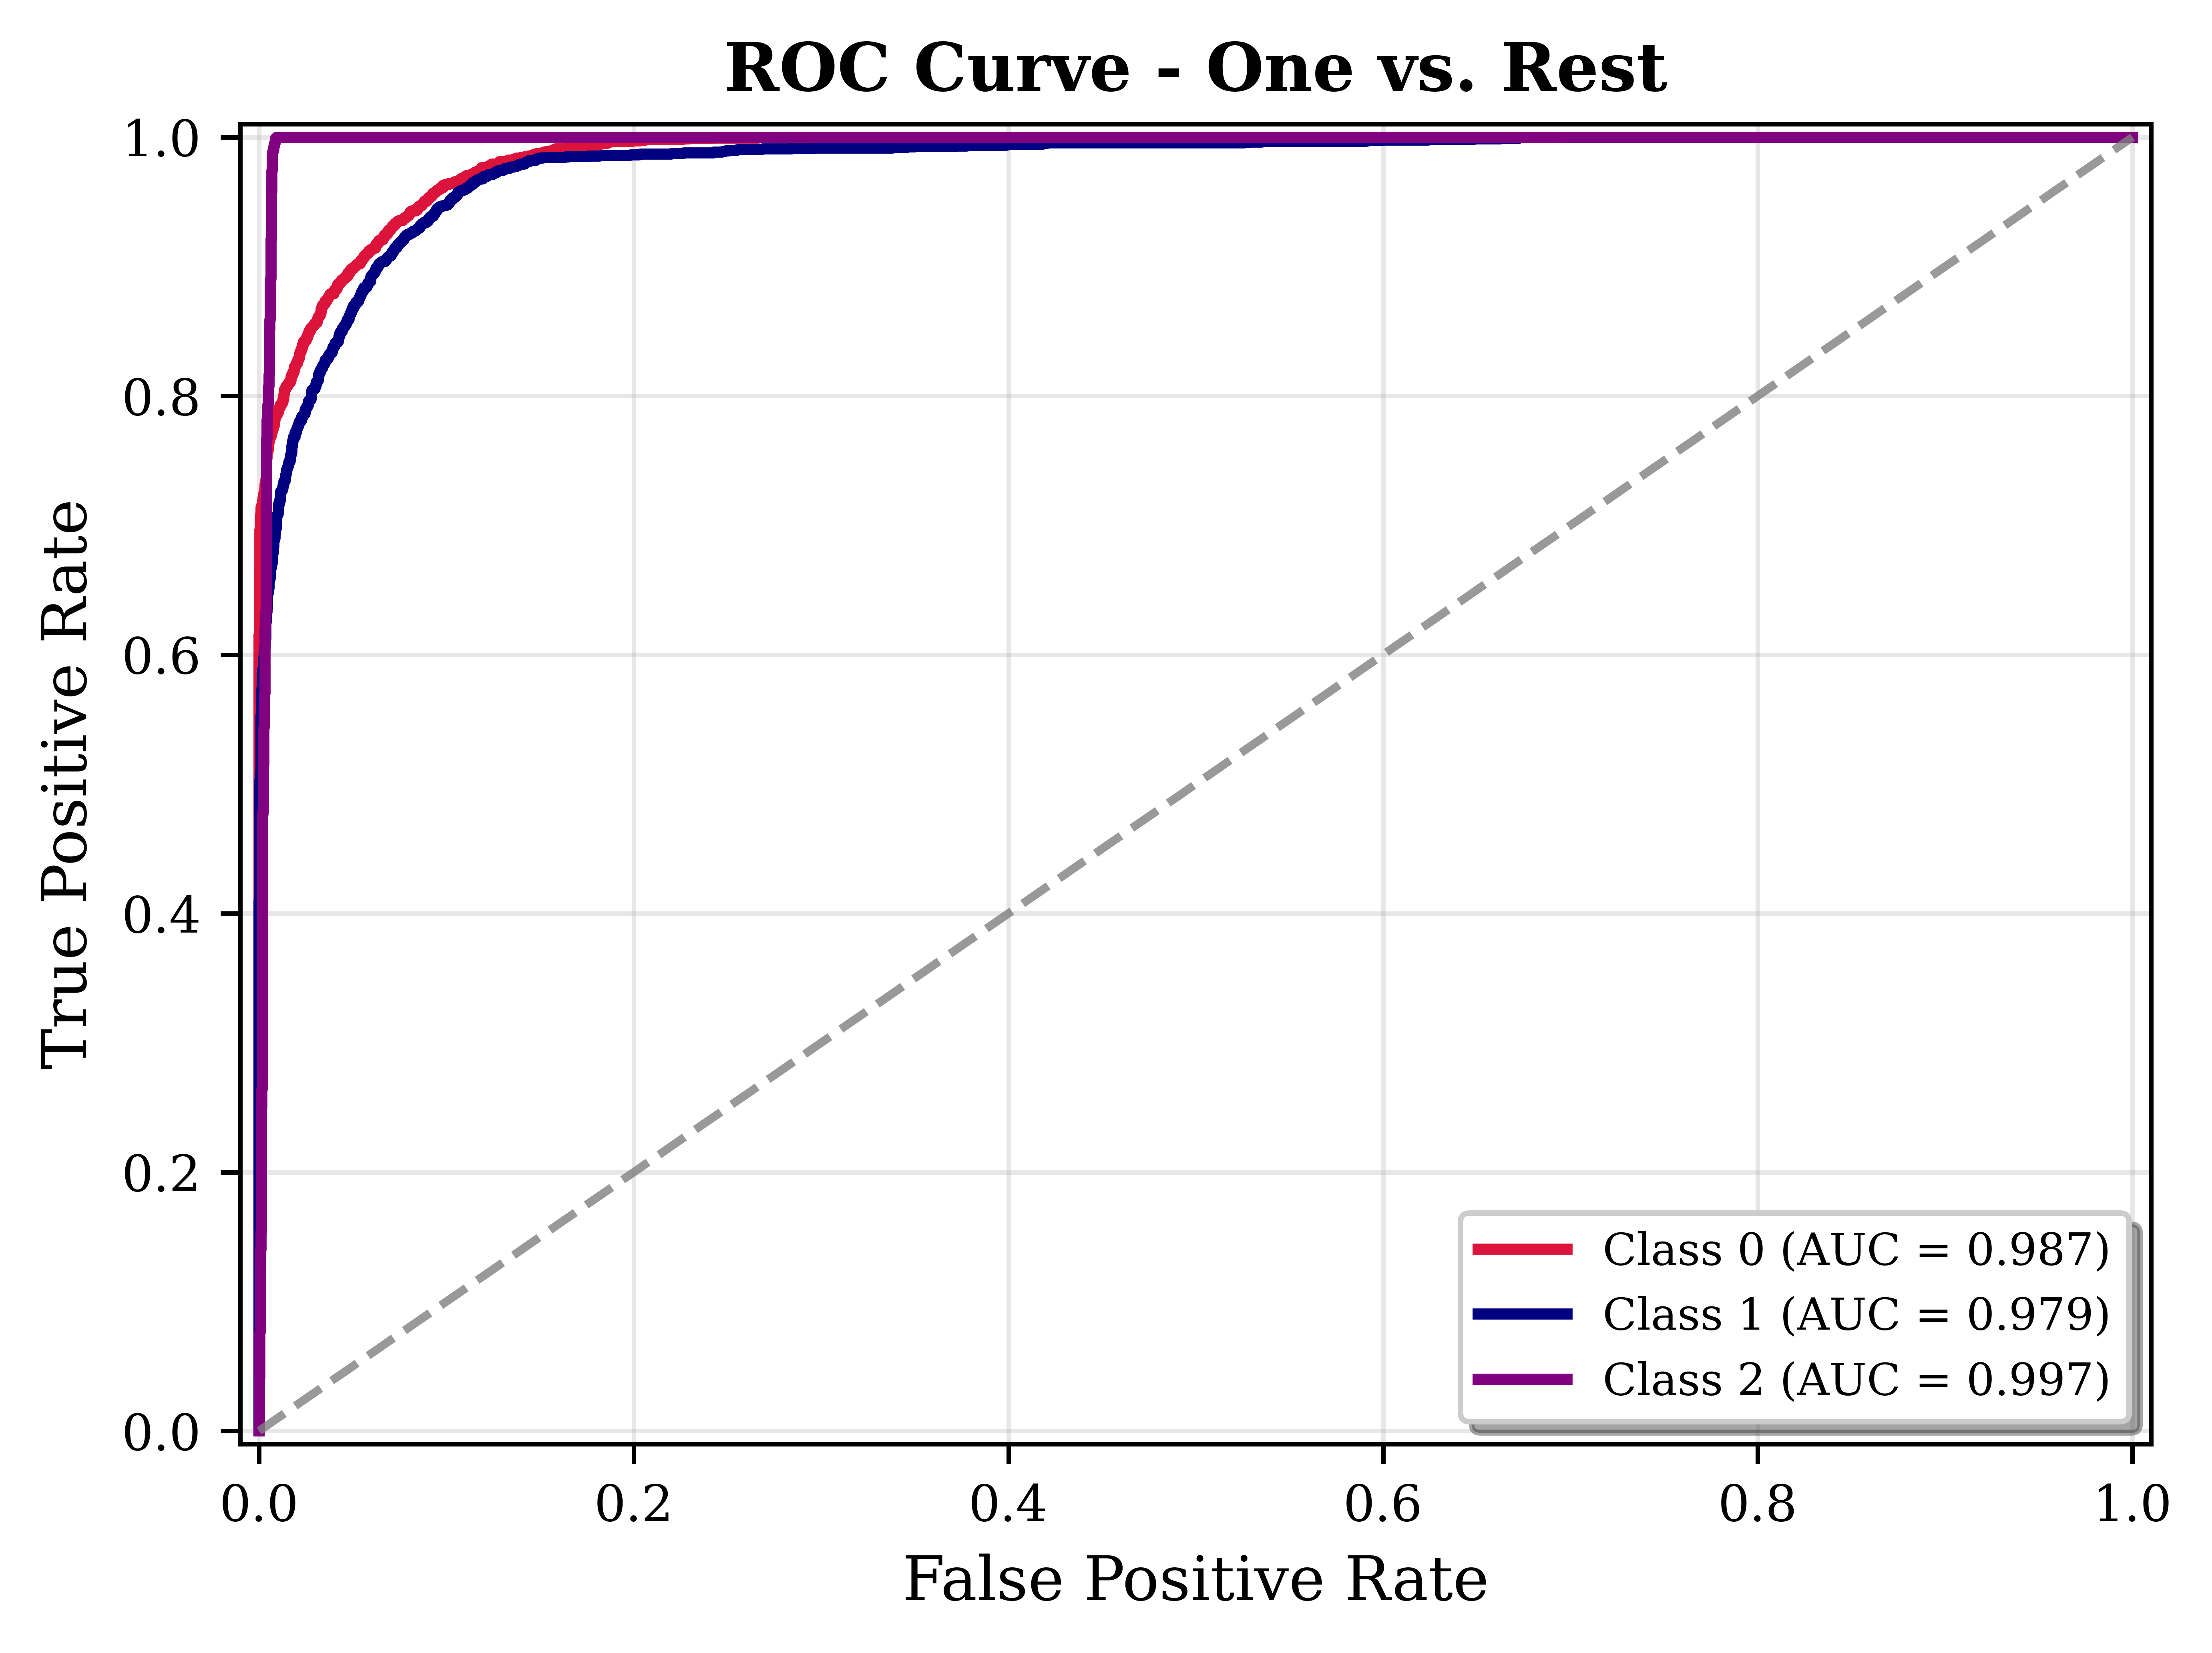

validation_loss: 0.1802, validation_accuracy: 92.41%



100%|██████████| 244/244 [00:25<00:00,  9.71it/s]


epoch [34/40], train_loss: 0.2062, train_accuracy: 91.27%, Time:25.13 seconds
validation_loss: 0.1723, validation_accuracy: 92.48%



100%|██████████| 244/244 [00:25<00:00,  9.62it/s]


epoch [35/40], train_loss: 0.1948, train_accuracy: 91.86%, Time:25.36 seconds
validation_loss: 0.1735, validation_accuracy: 92.79%



100%|██████████| 244/244 [00:25<00:00,  9.61it/s]


epoch [36/40], train_loss: 0.1978, train_accuracy: 91.78%, Time:25.40 seconds
validation_loss: 0.2308, validation_accuracy: 90.34%



100%|██████████| 244/244 [00:25<00:00,  9.45it/s]


epoch [37/40], train_loss: 0.1904, train_accuracy: 91.84%, Time:25.82 seconds
Calculating ROC AUC curves on validation set...
Class 0 AUC: 0.9890
Class 1 AUC: 0.9844
Class 2 AUC: 0.9981


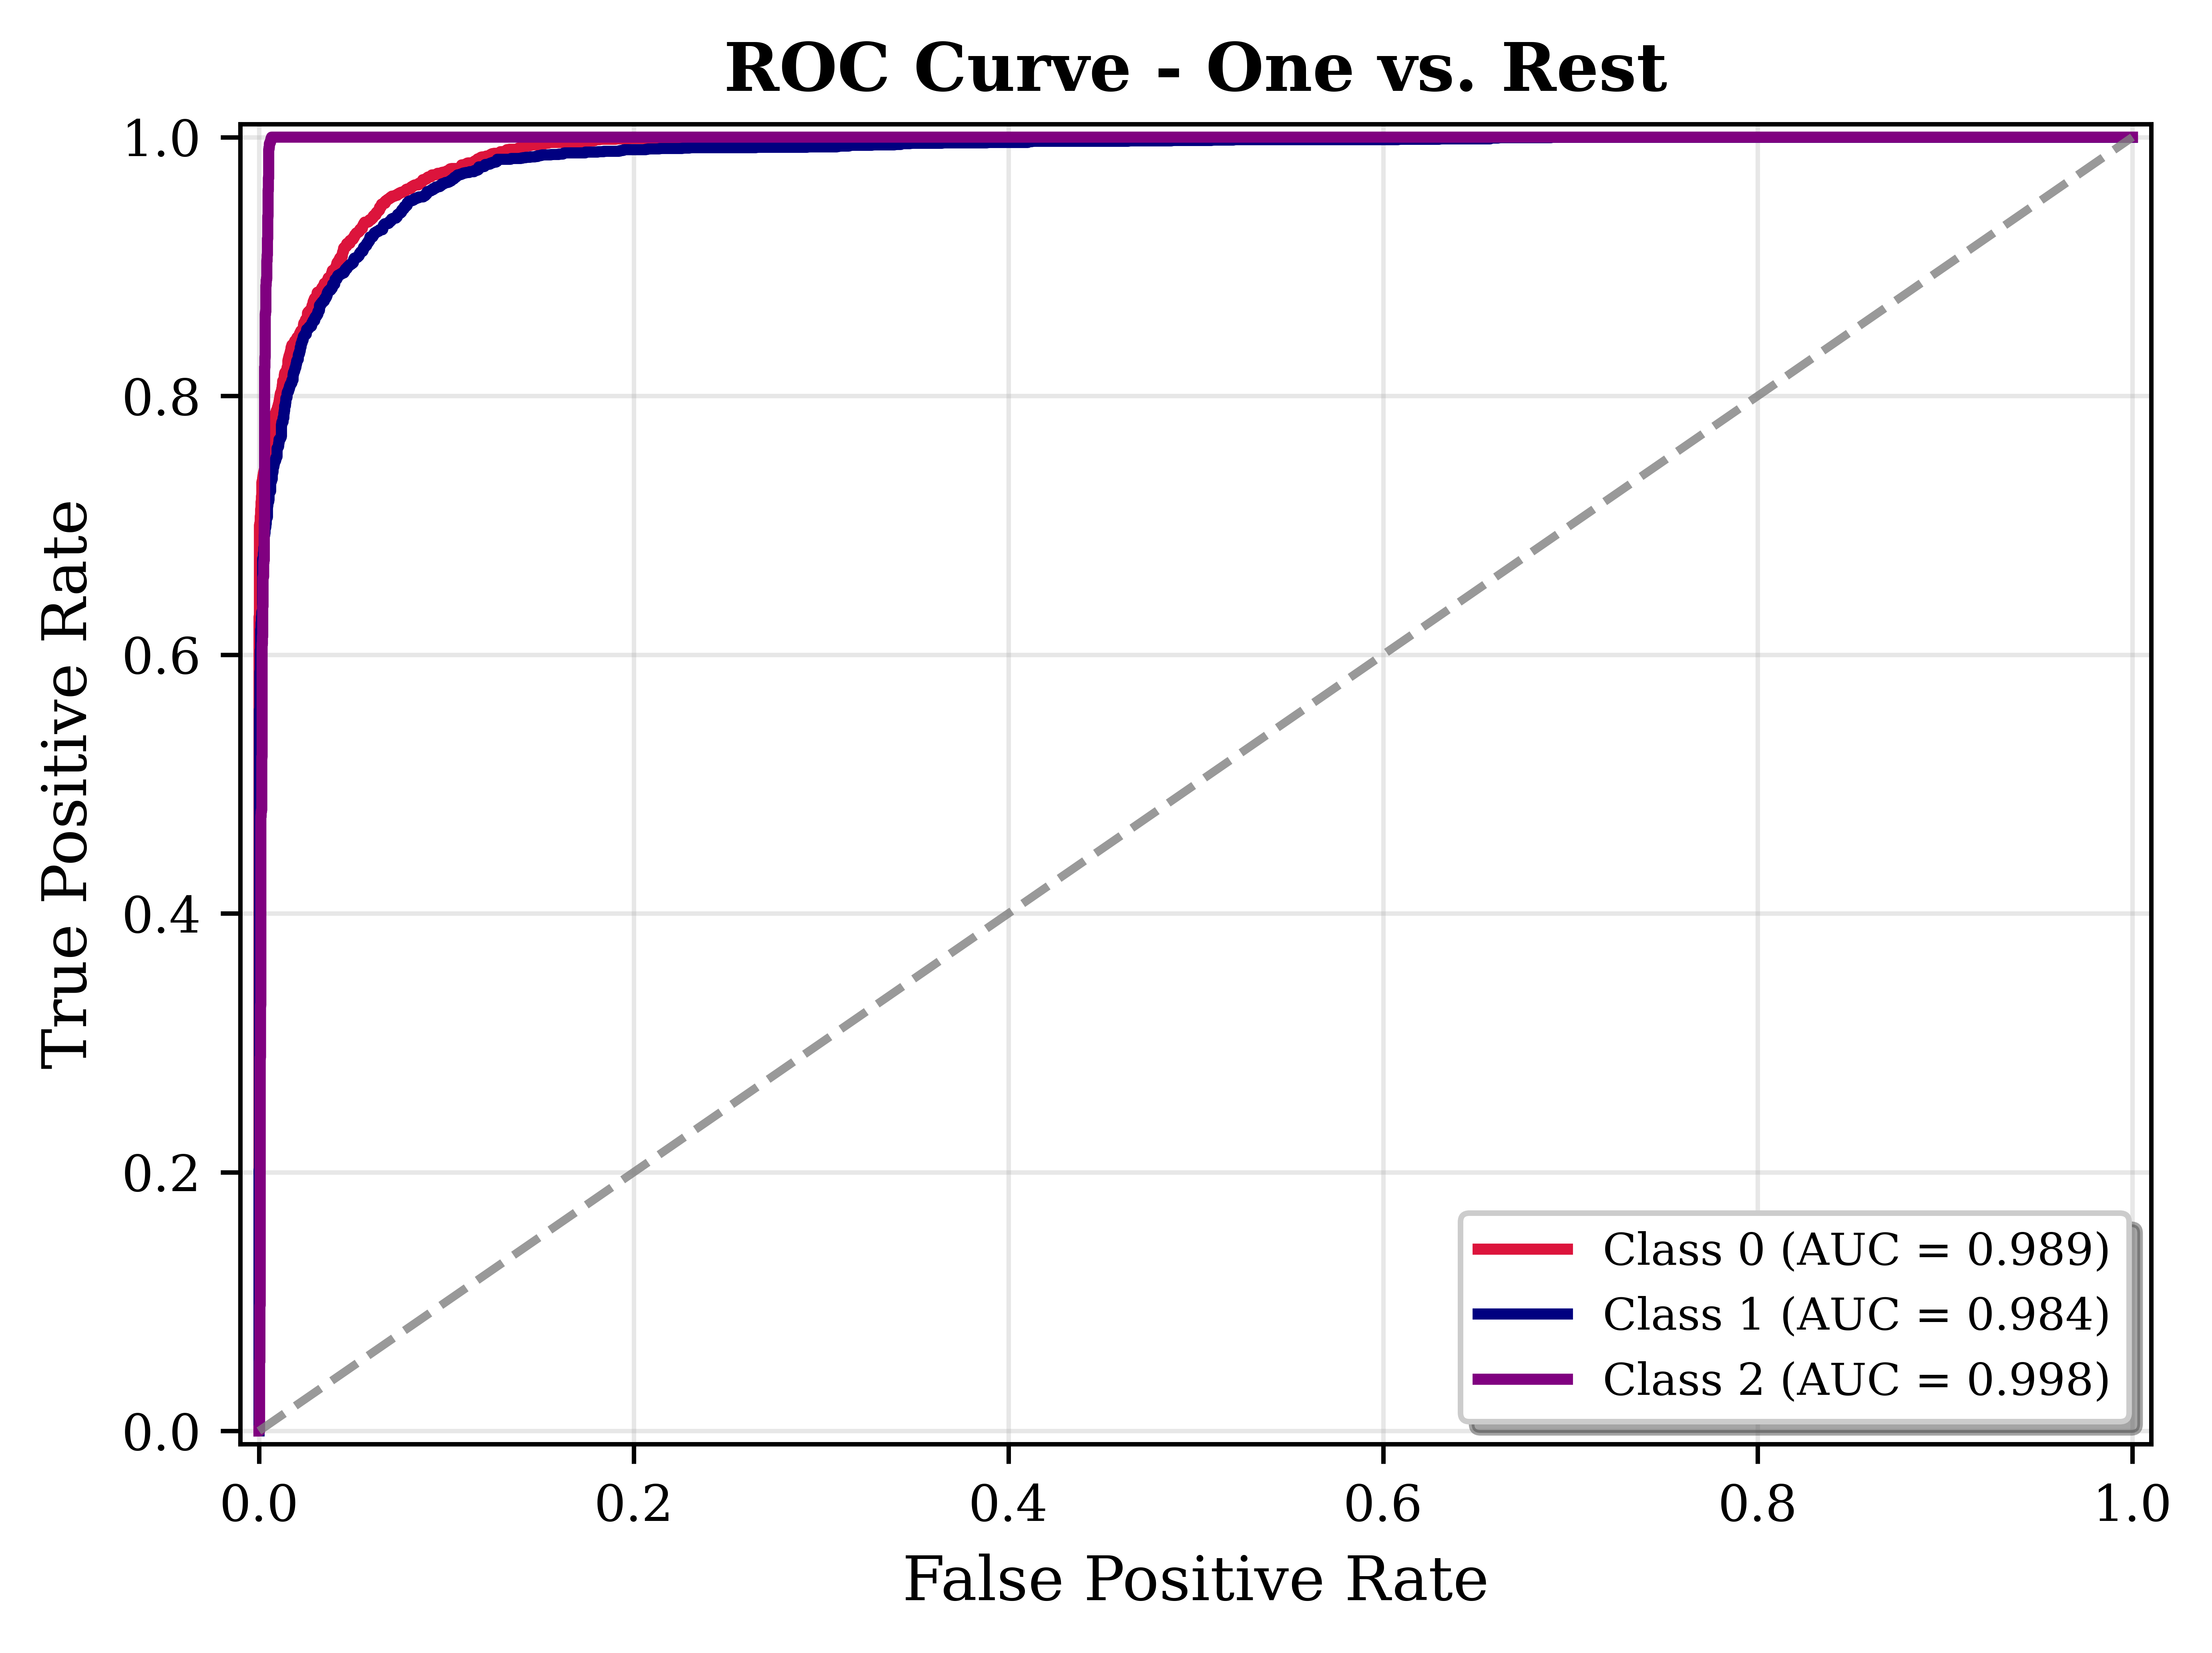

validation_loss: 0.1547, validation_accuracy: 93.34%



100%|██████████| 244/244 [00:25<00:00,  9.65it/s]


epoch [38/40], train_loss: 0.1796, train_accuracy: 92.49%, Time:25.29 seconds
validation_loss: 0.2007, validation_accuracy: 92.18%



100%|██████████| 244/244 [00:24<00:00,  9.95it/s]


epoch [39/40], train_loss: 0.1788, train_accuracy: 92.55%, Time:24.52 seconds
validation_loss: 0.1515, validation_accuracy: 93.19%



100%|██████████| 244/244 [00:25<00:00,  9.51it/s]


epoch [40/40], train_loss: 0.1838, train_accuracy: 92.28%, Time:25.67 seconds
validation_loss: 0.1792, validation_accuracy: 92.55%



<Figure size 12000x6000 with 0 Axes>

In [10]:
## S3 : TRAINING ## 
set_seed(HP['seed'])    

pretrained_model = torch.load(model_path) 
model = MAE_encoder(pretrained_model).to( device )
print( 'Trainable parameters :', sum(p.numel() for p in model.parameters() if p.requires_grad) )

trainer = Trainer_finetune(model,device, HP)
trainer.model_train(train_loader, val_loader)   


##### *5.4 Inference*

Test Accuracy ( Top 1 ): 92.36 % 

Confusion Matrix:
[[5596  453    0]
 [ 682 5005  226]
 [   0    0 5860]]
Class 0 AUC: 0.9886
Class 1 AUC: 0.9812
Class 2 AUC: 0.9984


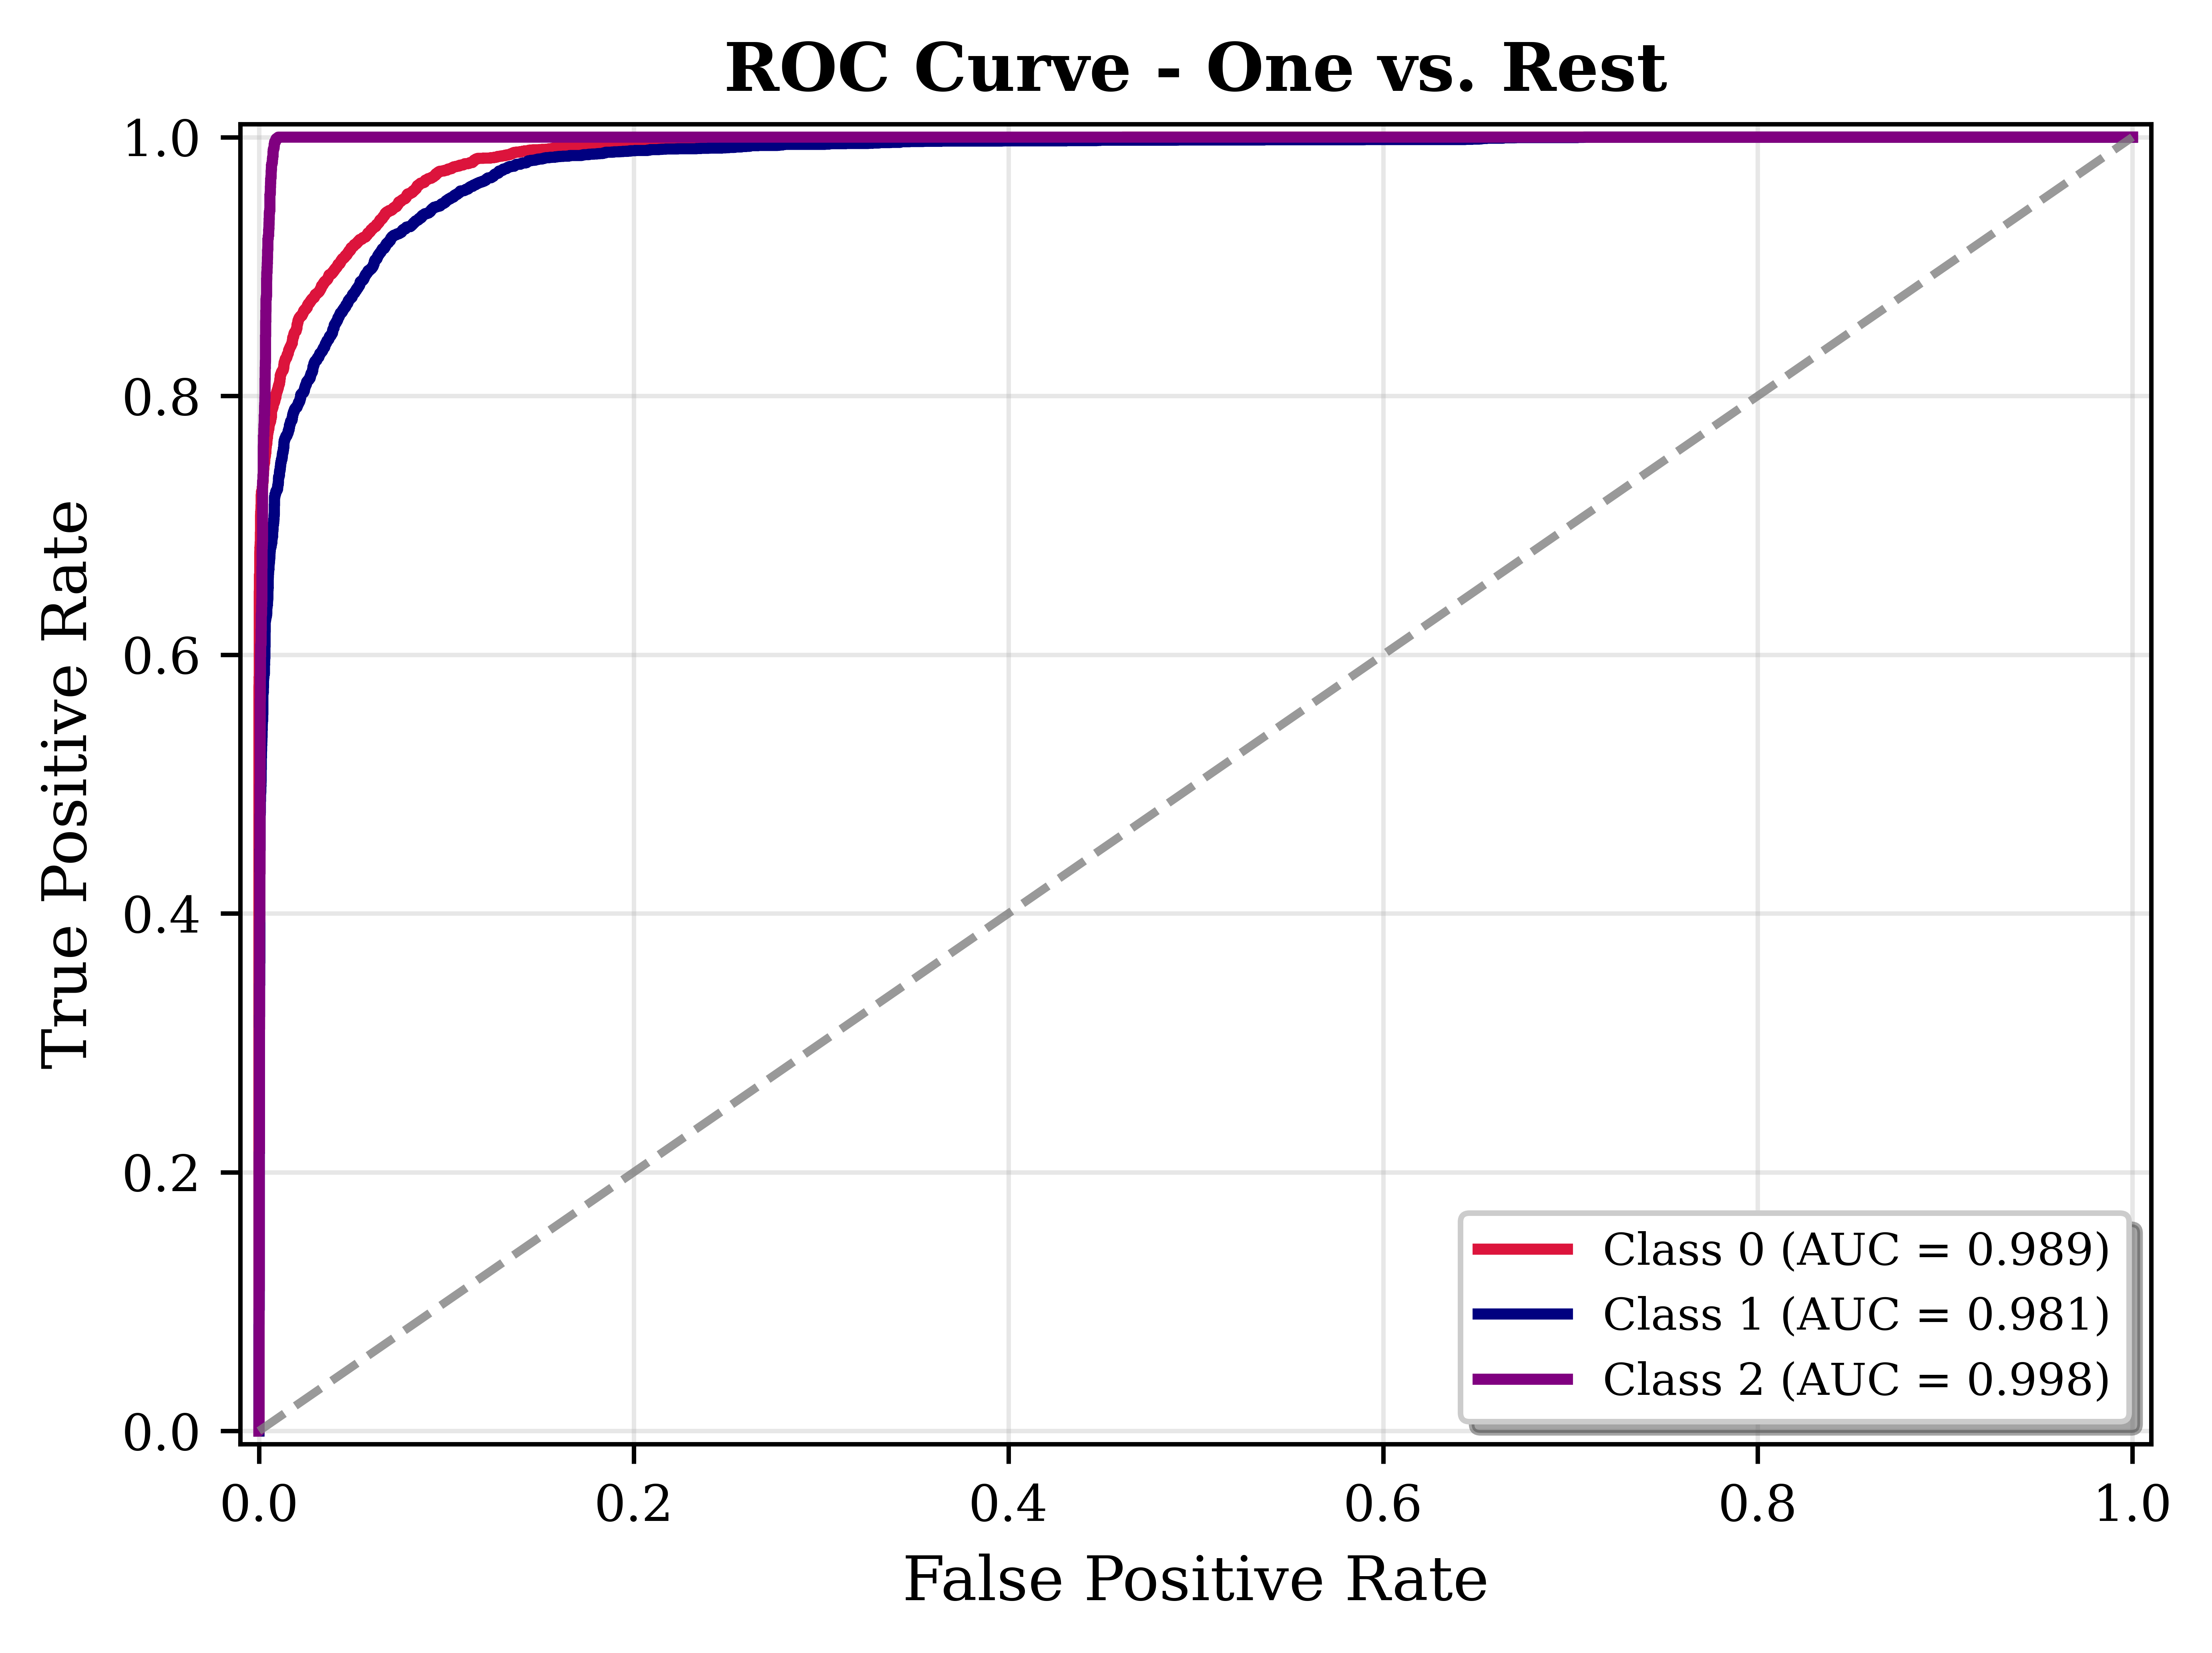

In [11]:


# --- Inference and Data Collection ---
model.eval()
all_preds = []
all_labels = []
all_probs = []  # probabilities for ROC calculation

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # (B, num_classes)
        _, predicted = torch.max(outputs, dim=1) # (B,)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Obtain softmax probabilities
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds) # (N,)
all_labels = np.array(all_labels) # (N,)
all_probs = np.array(all_probs) # (N, num_classes)

# Compute and print overall accuracy
accuracy = 100 * np.mean(all_preds == all_labels)
print(f"Test Accuracy ( Top 1 ): {accuracy:.2f} % ")

# Compute confusion matrix (optional)
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

# --- ROC Curve Calculation per Class ---

ROC_AUC_curves(all_labels,all_probs)

# Test dataset   : {'axion_copy': 5968, 'cdm': 5987, 'no_sub': 5867}
